In [1]:
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




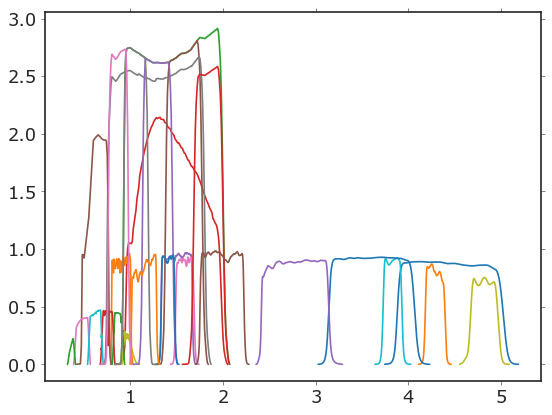

In [2]:
#plot overlap of filters
#f='../../splat/resources/Filters/UKIRT_UKIDSS.K.txt'

#PUTTING NEW FILTERS ON THE MICRON WAVELENGTH SCALE
for f in glob.glob('/users/caganze/research/splat/resources/filters/*.dat'):

        d=pd.read_csv(f, names=['LAM', 'TRANSMISSION'], delim_whitespace=True).astype(float)
        d['LAM']= d['LAM']/10_000
        #print (f)
        d.to_csv(f.replace('.dat', '.txt'), sep=' ', index=False)
        plt.plot(d.LAM, d.TRANSMISSION)
        #print (d)


In [3]:
#add WISE 
WISE_MAGS={'i': (23.8, 0.1),
          'z': (20.147, 0.08),
          'y': (18.942, 0.13),
          'J': (17.291, 0.044)}

wise_df=pd.Series()
wise_df['spt']=38
wise_df['teff']=800
wise_df['names']='WISE1810−1010.'
for p in ['LSST', 'SDSS', 'PANSTARRS']:
    wise_df[p+'_G']=np.nan
    wise_df[p+'_G_er']=np.nan
    wise_df[p+'_R']=np.nan
    wise_df[p+'_R_er']=np.nan
    wise_df[p+'_I']=WISE_MAGS['i'][0]-5*np.log10(8.9/10)
    wise_df[p+'_I_er']=0.1
    wise_df[p+'_Z']=WISE_MAGS['z'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Z_er']=0.1
    wise_df[p+'_Y']=WISE_MAGS['y'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Y_er']=0.15

In [4]:
#compute conversions from Gaia to LSST
def compute_lsst_mags(gaia_id, gmag):
    #read spectrum
    vals={'source_id':gaia_id}
    try:
        sp=read_gaia_spec(gaia_id)
        for m in ['LSST_G', 'LSST_R', 'LSST_I', 'LSST_Y', 'LSST_Z']:
            color= get_colors(s, 'GAIA_G', m)
            vals.update({m:(color[0]+gmag, color[1])})
    except:
        pass
        
    return vals


def get_correct_filter_name(flt):
    #reformat from by 
    f= flt.split('_')
    if f[-1]=='ps1':
        return 'PANSTARRS_'+(f[0]).upper()
    else:
        return  flt


def spt_to_teff_pec(spt, sd=True):
    return spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt_pec(teff, sd=True):
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
    
    
def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:  
            return  spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
    
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1000, xerr=0.0)
    return vals, unc

#functions
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=4.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
 
def fit_spline_nsigma_clipping(x, y, y_unc, sigma=4.):
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    while n_remove > 0:
        #best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        best_fit=UnivariateSpline(x[not_clipped], y[not_clipped])
        norm_res = (np.abs(y - best_fit(x)))/(y_unc)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
    return UnivariateSpline(x[not_clipped], y[not_clipped])
 

#label sd, usd and esd
def get_sd_type(spt):
    for c in ['sd', 'esd', 'usd']:
        if spt.startswith(c):
            return c
        
def compute_colors(s, xkey, ykey):
    #print (xkey, ykey)
    xmag= filterMag(s ,xkey)
    ymag= filterMag(s, ykey)
    return xmag[0]-ymag[0], (xmag[1]**2+ymag[1]**2)**0.5

In [5]:
filterMag

<function splat.photometry.filterMag(sp, filt, *args, **kwargs)>

In [6]:
#spectroscopic data for color information

In [7]:
zhang_tpls= np.load('/Volumes/LaCie/popsimsdata/zhang_subdwarfs_templates.npy',  allow_pickle=True)[0]

lodieu_tpls= np.load('/Volumes/LaCie/popsimsdata/lodieu_templates.npy',  allow_pickle=True)[0]

lepine_tpls= np.load('/Volumes/LaCie/popsimsdata/lepinelpsm_subdwarfs_templates.npy',  allow_pickle=True)[0]

kesseli_tpls= np.load('/Volumes/LaCie/popsimsdata/kesseli_subdwarfs_templates.npy',  allow_pickle=True)[0]

In [8]:
#PUTTING NEW FILTERS ON THE MICRON WAVELENGTH SCALE
#for f in glob.glob('/users/caganze/research/splat/resources/filters/*.dat'):
#        d=pd.read_csv(f, names=['LAM', 'TRANSMISSION'], delim_whitespace=True).astype(float)
#        d['LAM']= d['LAM']/10_000
#        #print (f)
#        d.to_csv(f.replace('.dat', '.txt'), sep=' ', index=False)
#        plt.plot(d.LAM, d.TRANSMISSION)
#print (d)

In [9]:
#define all color terms to compute
COLOR_TERMS=[#'Gaia_GandLSST_G',
             #'Gaia_RandLSST_R',
             
            'SDSS_GandLSST_G',
            'SDSS_RandLSST_R',
            'SDSS_IandLSST_I',
            'SDSS_ZandLSST_Z',
             
            #LSST
            'PANSTARRS_RandLSST_R',
            'PANSTARRS_IandLSST_I',
            'PANSTARRS_ZandLSST_Z',
            'PANSTARRS_YandLSST_Y',
    
            'LSST_GandLSST_R',
            'LSST_RandLSST_Z',
            'LSST_IandLSST_Z',
             
             #VISTA
             'PANSTARRS_ZandVISTA_Z',
             'PANSTARRS_YandVISTA_Y',
             '2MASS_JandVISTA_J',
             '2MASS_HandVISTA_H',
             '2MASS_KandVISTA_KS',
             
             #UKIDS
             'PANSTARRS_YandUKIDSS_Y',
             'PANSTARRS_ZandUKIDSS_Z',
             'PANSTARRS_ZandUKIDSS_J',
             '2MASS_HandUKIDSS_H',
             '2MASS_KandUKIDSS_K',
            
    
             #JWST NIRISS
             'PANSTARRS_ZandNIRISS_F090W',
             '2MASS_JandNIRISS_F115W',
             '2MASS_JandNIRISS_F150W',
             '2MASS_HandNIRISS_F200W',
    
             #ROMAN
             'PANSTARRS_ZandWFI_R062',
             'PANSTARRS_ZandWFI_Z087',
             'PANSTARRS_ZandWFI_Y106',
             '2MASS_JandWFI_J129',
             '2MASS_HandWFI_H158',
             '2MASS_HandWFI_F184',
             '2MASS_JandWFI_Prism',
             '2MASS_JandWFI_Grism',
             
             #EUCLID
             'PANSTARRS_ZandEUCLID_Y',
             '2MASS_JandEUCLID_J',
             '2MASS_HandEUCLID_H',
    
             #other colors
             'PANSTARRS_Zand2MASS_J',\
             'PANSTARRS_ZandVISTA_J',\
             'SDSS_ZandUKIDSS_J',
             'SDSS_ZandVISTA_J']
    
    
    
            #euclid
    
            #Roman

In [10]:

             

zhang_sd_corrections={}
for c in COLOR_TERMS:
    zhang_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(zhang_tpls['spectra'])]})
    
lodieu_sd_corrections={}
for c in COLOR_TERMS:
    lodieu_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lodieu_tpls['spectra'])]})
    
lepine_sd_corrections={}
for c in COLOR_TERMS:
    lepine_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lepine_tpls['spectra'])]})

100%|██████████████████████████████████████| 3137/3137 [00:10<00:00, 312.34it/s]


100%|██████████████████████████████████████| 3137/3137 [00:27<00:00, 115.38it/s]


In [11]:
kesseli_sd_corrections={}
for c in COLOR_TERMS:
    kesseli_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(kesseli_tpls['spectra'])]})

100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 108.77it/s]


In [12]:
#add spectral type information 
zhang_color_df=pd.DataFrame(zhang_sd_corrections)
zhang_color_df['spt']=zhang_tpls['spt']
zhang_color_df['numspt']=[splat.typeToNum(x) for x in zhang_tpls['spt']]
zhang_color_df['teff']=[ spt_to_teff_pec(x, sd=True) for x in zhang_color_df['numspt']]
zhang_color_df['subdwarf_type']=[get_sd_type(x) for x in zhang_tpls['spt']]
#only select M and L dwarfs
zhang_color_df=zhang_color_df[zhang_color_df.numspt>=15]

#add spectral type information 
lodieu_color_df=pd.DataFrame(lodieu_sd_corrections)
lodieu_color_df['spt']=[x.name.split('_')[0] for x in lodieu_tpls['spectra'] ]
lodieu_color_df['numspt']=[splat.typeToNum(x) for x in lodieu_color_df['spt'].values]
lodieu_color_df['teff']=[spt_to_teff_pec(x, sd=True) for x in lodieu_color_df['numspt'].values]
lodieu_color_df['subdwarf_type']=[get_sd_type(x) for x in lodieu_color_df['spt'].values]
#this should only have r and i (no z, y or g for 0.6-0.8 micron specrtra)
lodieu_color_df=lodieu_color_df[lodieu_color_df.numspt>=15]

#add spectral type information 
lepine_color_df=pd.DataFrame(lepine_sd_corrections)
lepine_color_df['spt']=lepine_tpls['sptype']
lepine_color_df['numspt']=[splat.typeToNum(x) for x in lepine_color_df['spt'].values]
lepine_color_df['teff']=[spt_to_teff_pec(x, sd=True) for x in lepine_color_df['numspt'].values]
lepine_color_df['subdwarf_type']=[get_sd_type(x) for x in lepine_color_df['spt'].values]
lepine_color_df=lepine_color_df[lepine_color_df.numspt>=15]



#add spectral type information 
kesseli_color_df=pd.DataFrame(kesseli_sd_corrections)
kesseli_color_df['spt']=kesseli_tpls['sptype']
kesseli_color_df['numspt']=[splat.typeToNum(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df['teff']=[spt_to_teff_pec(x, sd=True) for x in kesseli_color_df['numspt'].values]
kesseli_color_df['subdwarf_type']=[get_sd_type(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df=kesseli_color_df[kesseli_color_df.numspt>=15]


In [13]:
for k in ['Gaia_GandLSST_G',  'SDSS_GandLSST_G', 'SDSS_ZandLSST_Z',
          'PANSTARRS_ZandLSST_Z', 'PANSTARRS_YandLSST_Y', 'LSST_GandLSST_R', 'LSST_RandLSST_Z',
       'LSST_IandLSST_Z']:
    lepine_color_df[k]=[(np.nan, np.nan) for x in range(len(lepine_color_df))]

In [14]:
#lodieu_color_df['SDSS_ZandLSST_Z']

In [15]:
combined_colors_df=pd.concat([zhang_color_df, lodieu_color_df, lepine_color_df])

In [16]:
combined_colors_df=(combined_colors_df[combined_colors_df.numspt>10]).reset_index(drop=True)

In [17]:
combined_colors_df.columns

Index(['SDSS_GandLSST_G', 'SDSS_RandLSST_R', 'SDSS_IandLSST_I',
       'SDSS_ZandLSST_Z', 'PANSTARRS_RandLSST_R', 'PANSTARRS_IandLSST_I',
       'PANSTARRS_ZandLSST_Z', 'PANSTARRS_YandLSST_Y', 'LSST_GandLSST_R',
       'LSST_RandLSST_Z', 'LSST_IandLSST_Z', 'PANSTARRS_ZandVISTA_Z',
       'PANSTARRS_YandVISTA_Y', '2MASS_JandVISTA_J', '2MASS_HandVISTA_H',
       '2MASS_KandVISTA_KS', 'PANSTARRS_YandUKIDSS_Y',
       'PANSTARRS_ZandUKIDSS_Z', 'PANSTARRS_ZandUKIDSS_J',
       '2MASS_HandUKIDSS_H', '2MASS_KandUKIDSS_K',
       'PANSTARRS_ZandNIRISS_F090W', '2MASS_JandNIRISS_F115W',
       '2MASS_JandNIRISS_F150W', '2MASS_HandNIRISS_F200W',
       'PANSTARRS_ZandWFI_R062', 'PANSTARRS_ZandWFI_Z087',
       'PANSTARRS_ZandWFI_Y106', '2MASS_JandWFI_J129', '2MASS_HandWFI_H158',
       '2MASS_HandWFI_F184', '2MASS_JandWFI_Prism', '2MASS_JandWFI_Grism',
       'PANSTARRS_ZandEUCLID_Y', '2MASS_JandEUCLID_J', '2MASS_HandEUCLID_H',
       'PANSTARRS_Zand2MASS_J', 'PANSTARRS_ZandVISTA_J', 'SDSS_ZandUK

In [18]:
#load in cross-matched tables
zhang_abs_mags_tables=ascii.read('/volumes/LaCie/zhang_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
zhang_abs_mags_tables['numspt']=zhang_abs_mags_tables.sptype.apply(splat.typeToNum).values
zhang_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in zhang_abs_mags_tables.sptype]

simbad_abs_mags_tables=ascii.read('/volumes/LaCie/simbad_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
simbad_abs_mags_tables['numspt']=simbad_abs_mags_tables.simbad_type.apply(splat.typeToNum).values
simbad_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in simbad_abs_mags_tables.simbad_type]


abs_mags_tables=pd.concat([zhang_abs_mags_tables, simbad_abs_mags_tables] )
abs_mags_tables['teff']=[ spt_to_teff_pec(x, sd=True) for x in abs_mags_tables['numspt']]

In [19]:
#rename some columns
best_columns={}
for k in ['g', 'r', 'i', 'z', 'y']:
    best_columns.update({'absolute_PS1{}mag'.format(k):'PANSTARRS_{}'.format(k.upper())})
    best_columns.update({'absolute_PS1{}mag_er'.format(k):'PANSTARRS_{}_er'.format(k.upper())})
    best_columns.update({'use_mag_PS1{}mag'.format(k): 'use_PANSTARRS_{}'.format(k.upper())})
    

for k in ['J','H']:
    best_columns.update({'absolute_{}mag'.format(k): '2MASS {}'.format(k)})
    best_columns.update({'absolute_{}mag_er'.format(k): '2MASS {}_er'.format(k)})
    best_columns.update({'use_mag_{}mag'.format(k): 'use_2MASS {}'.format(k)})

#using Ks and K interchangably
for k in ['K']:
    best_columns.update({'absolute_{}smag'.format(k): '2MASS {}'.format(k)})
    best_columns.update({'absolute_{}smag_er'.format(k): '2MASS {}_er'.format(k)})
    best_columns.update({'use_mag_{}smag'.format(k): 'use_2MASS {}'.format(k)})

best_sample= pd.read_pickle('/Volumes/LaCie/Best2018_masked.csv.gz').rename(columns=best_columns)
best_sample['spt']=best_sample.NumType.values.astype(float)
best_sample['teff']=[ spt_to_teff_pec(x, sd=False) for x in best_sample.spt.values]

In [20]:
(best_sample.spt.max())

39.0

In [21]:
#lepine_color_df['LSST_GandSDSS_R']
data=[ zhang_color_df, kesseli_color_df, lodieu_color_df, lepine_color_df]

labels=[ 'Zhang', 'Kesseli', 'Lodieu', 'Lepine']

colors=[ '#FF4136', '#111111', '#B10DC9', '#3D9970']

In [22]:
#FITS= {'colors_spt':{'subdwarfs':{}, 'dwarfs': {}},
#       'colors_teff':{'subdwarfs':{}, 'dwarfs': {}},
#       'absmags_spt':{'subdwarfs':{}, 'dwarfs': {}},
#       'absmags_teff':{'subdwarfs':{}, 'dwarfs': {}}}
FITS= np.load('/Volumes/LaCie/popsimsdata//abs_mag_relations.npy', allow_pickle=True)[0]

In [23]:
additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
all_keys

array(['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H',
       '2MASS K', '2MASS_H', '2MASS_J', '2MASS_K', 'EUCLID_H', 'EUCLID_J',
       'EUCLID_Y', 'LSST_G', 'LSST_I', 'LSST_R', 'LSST_Y', 'LSST_Z',
       'NIRISS_F090W', 'NIRISS_F115W', 'NIRISS_F150W', 'NIRISS_F200W',
       'PANSTARRS_I', 'PANSTARRS_R', 'PANSTARRS_Y', 'PANSTARRS_Z',
       'SDSS_G', 'SDSS_I', 'SDSS_R', 'SDSS_Z', 'UKIDSS_H', 'UKIDSS_J',
       'UKIDSS_K', 'UKIDSS_Y', 'UKIDSS_Z', 'VISTA_H', 'VISTA_J',
       'VISTA_KS', 'VISTA_Y', 'VISTA_Z', 'WFI_F184', 'WFI_Grism',
       'WFI_H158', 'WFI_J129', 'WFI_Prism', 'WFI_R062', 'WFI_Y106',
       'WFI_Z087'], dtype='<U12')

In [24]:
def get_sd_models(model='line2021'):
    #ADD models
    sdmodels=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_{}.npy'.format(model), allow_pickle=True)[0]
    additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
    all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
    model_vals=dict(zip(all_keys, []))


    #compute values from filtermags
    #ADD ADDITIONAL FITS FOR SLOAN AND 2 MASS TO TAKE ADAVTANGE OF METAL-POOR MODELS
    
    for k in all_keys:
        mags= np.vstack([filterMag(x, k) for x in sdmodels['spectra']])
        model_vals[k]=mags[:,0] 
        model_vals[k+'_er']= 0.#(mags[:,1]**2+ np.nanmedian(df_sd_dwarfs[k+'_er'])**2)**0.5#add a fudicial 0.1 scatter

    sdmodel_df=pd.DataFrame(model_vals)
    sdmodel_df['spt']=[ teff_to_spt_pec(x, sd=True) for x in sdmodels['teff']]
    sdmodel_df['spt']= np.array(sdmodel_df['spt'])
    sdmodel_df['teff']= sdmodels['teff']
    sdmodel_df['z']= sdmodels['z']
    sdmodel_df['logg']= sdmodels['logg']
    return sdmodel_df

In [25]:
#sdmodel_df_drift0= get_sd_models(model='drift')

sdmodel_df_line= get_sd_models(model='line2021')
sdmodel_df_cond= get_sd_models(model='cond')
sdmodel_df_ger= get_sd_models(model='gerasimov')

In [26]:
sdmodel_df_ger=(sdmodel_df_ger[sdmodel_df_ger.logg>4.]).reset_index(drop=True)

In [27]:
#(sdmodel_df_line[k.split('and')[1]])[mask_model]-(sdmodel_df_line[k.split('and')[0]])[mask_model],

In [28]:
#

In [29]:
from scipy.interpolate import UnivariateSpline

In [30]:
#for lepine spectra, we can only use r and i bands 

In [31]:
def bin_by_spt_bin(grid, xvals, yvals, yvalserr):
    #bin on a uniformly-spaced grid
    res=[]
    dx= grid[1]-grid[0]
    for x in grid:
        mask= np.logical_and(xvals>=x, xvals<x+dx)
        yx=np.nanmedian(yvals[mask])
        yxerr=(np.nanstd(yvals[mask])**2+np.nanmedian(yvalserr[mask])**2)**0.5
        
        res.append([yx, yxerr])
        
    return res
    

In [32]:
grid=np.arange(10, 40)

In [33]:
def plot_model_colors(model, met, ax, ax1, k, plot_kwargs):
    xkey=k.split('and')[0]
    ykey=k.split('and')[1]

    mask_model=model.z==met
    
    ax.errorbar(sdmodel_df_ger.spt[mask_model], (sdmodel_df_ger[xkey]-sdmodel_df_ger[ykey])[mask_model], \
                **plot_kwargs)
    ax1.errorbar(sdmodel_df_ger.teff[mask_model], (sdmodel_df_ger[xkey]-sdmodel_df_ger[ykey])[mask_model], \
                **plot_kwargs)
    return 

In [34]:
FITS['colors_spt']['esd']={}
FITS['colors_teff']['esd']={}
FITS['absmags_spt']['esd']={}
FITS['absmags_teff']['esd']={}

In [35]:
#this is so bad, for the colors maybe just fit the models, can't trust these spectra\

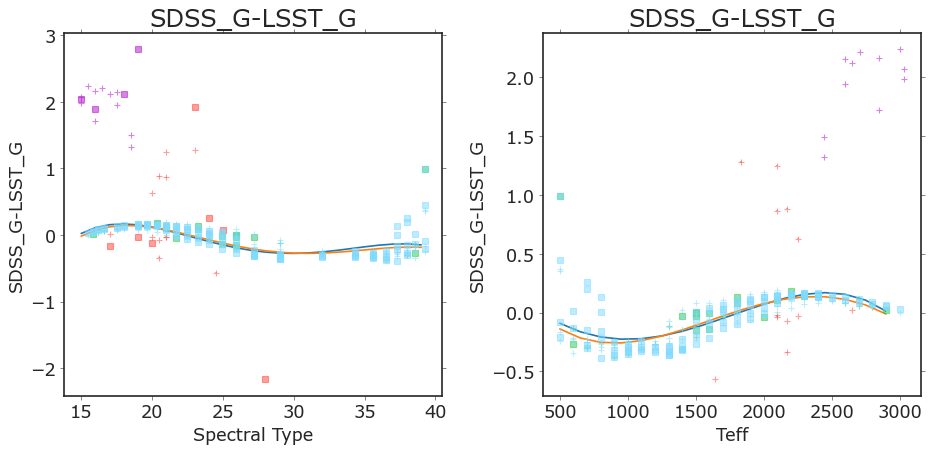

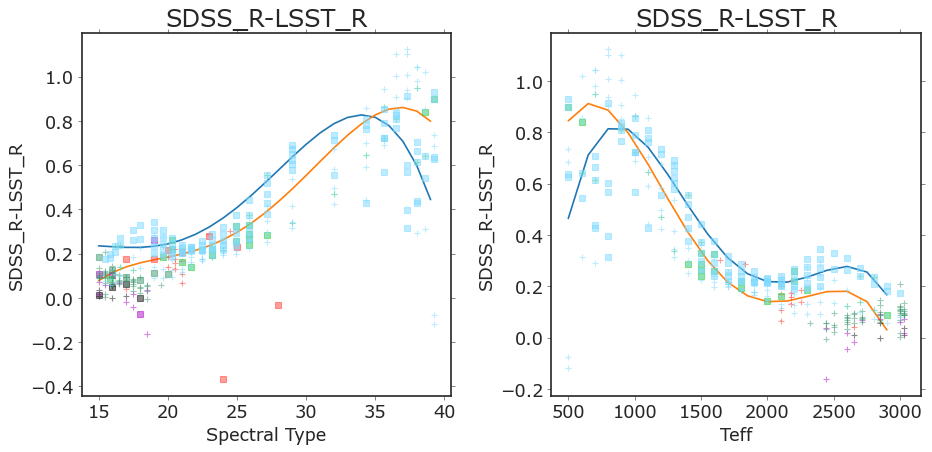

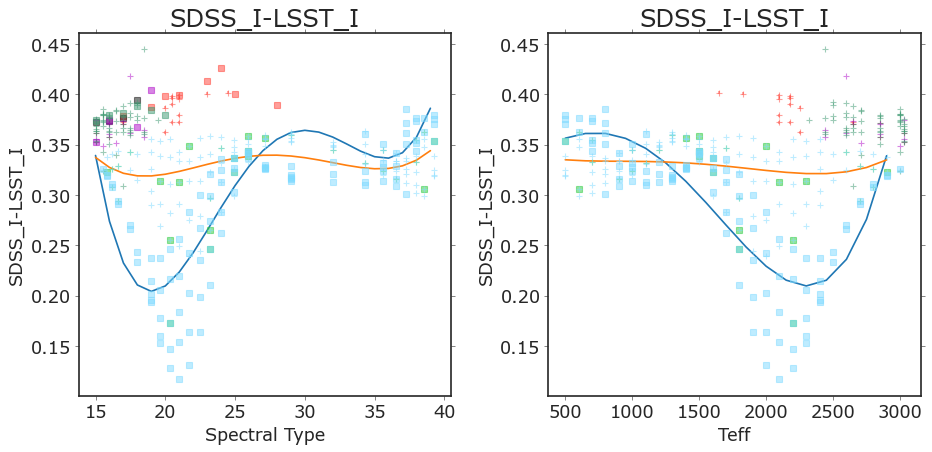

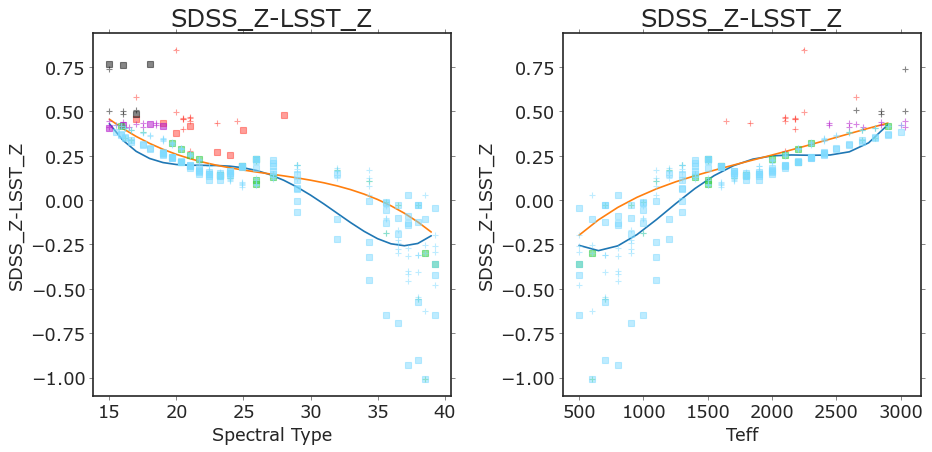

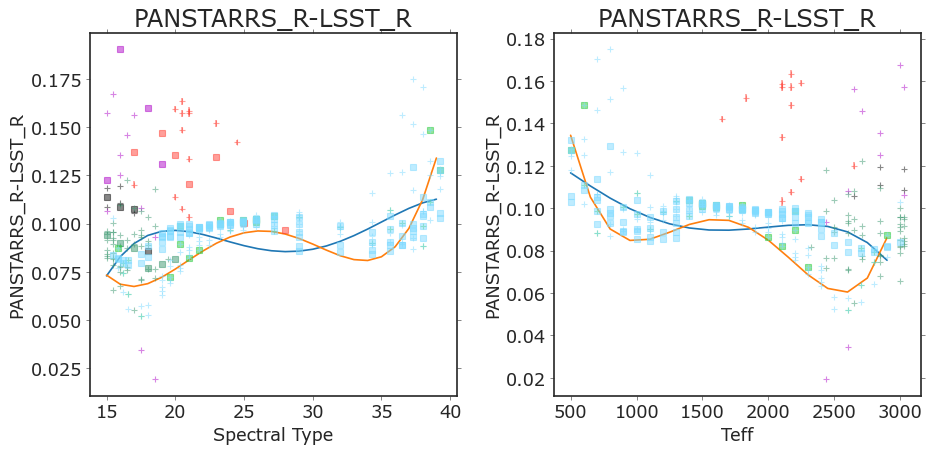

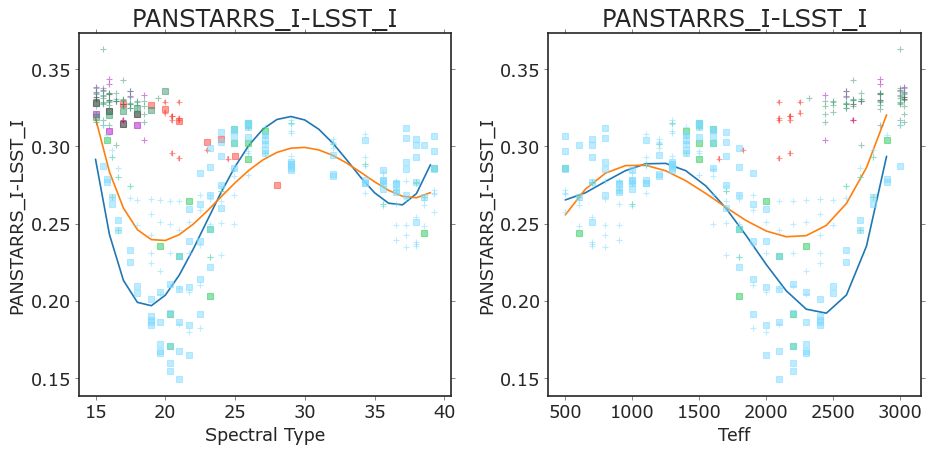

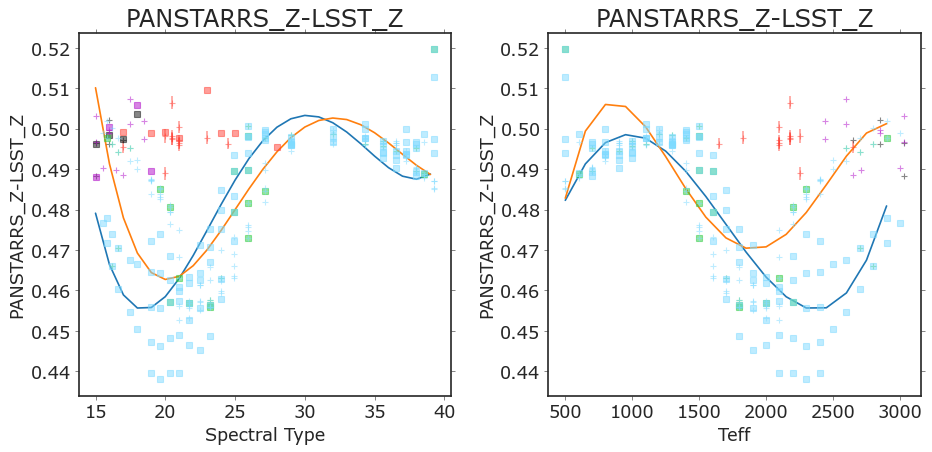

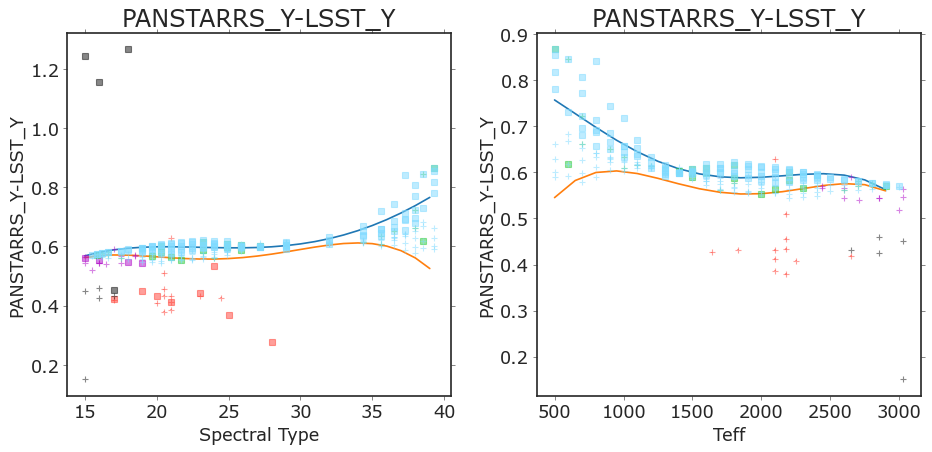

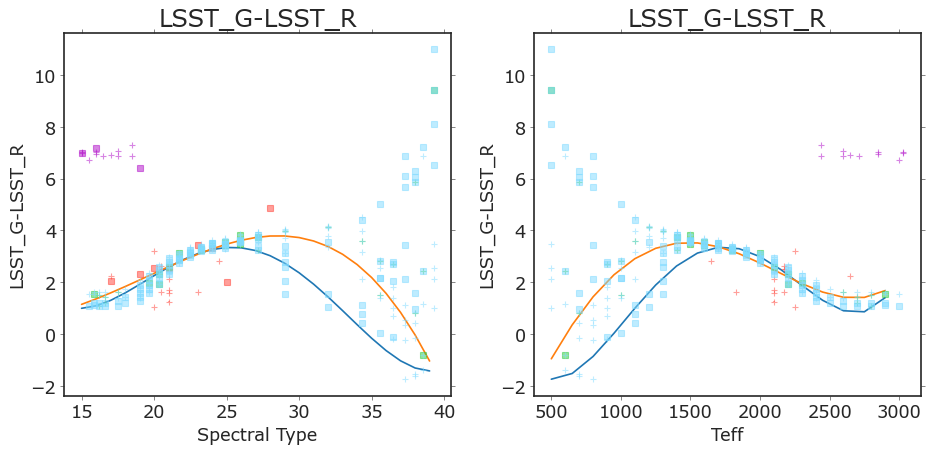

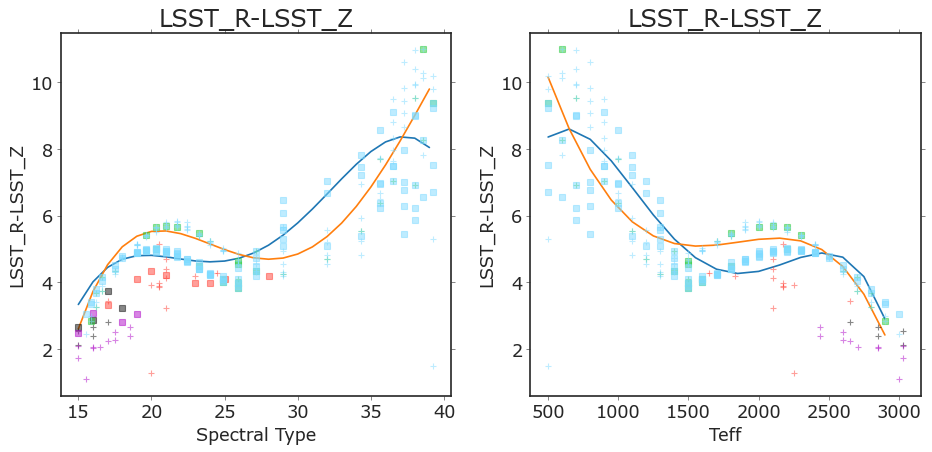

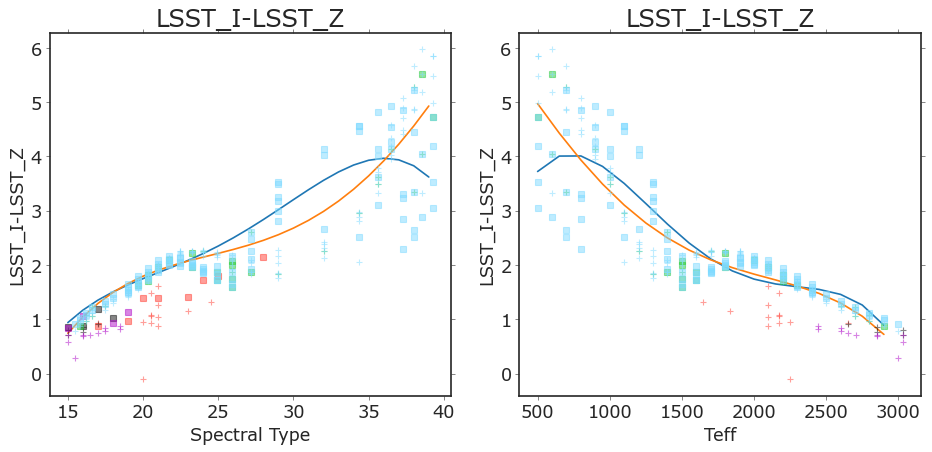

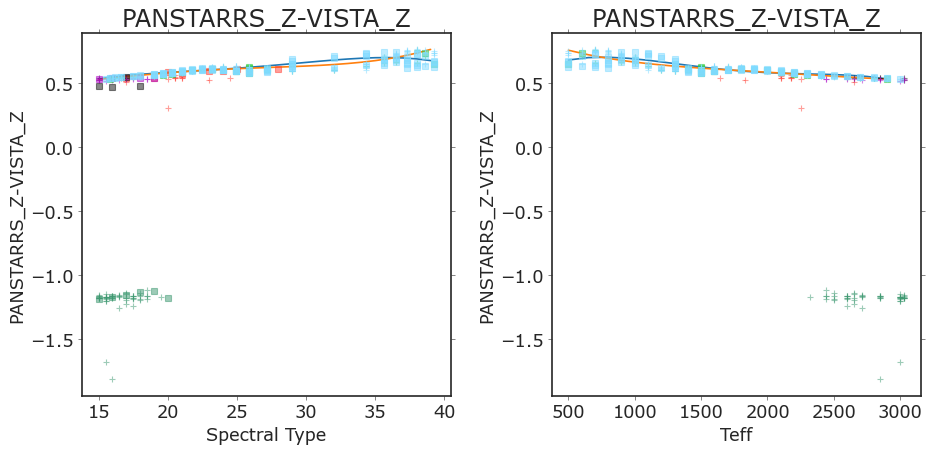

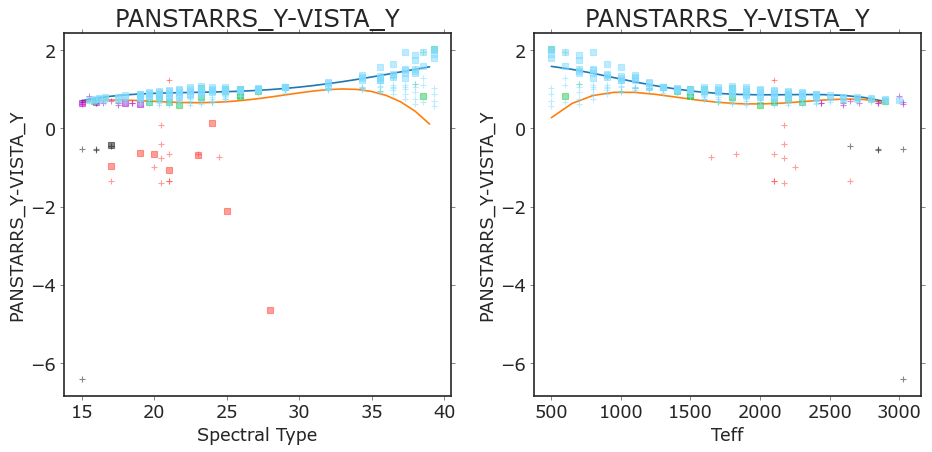

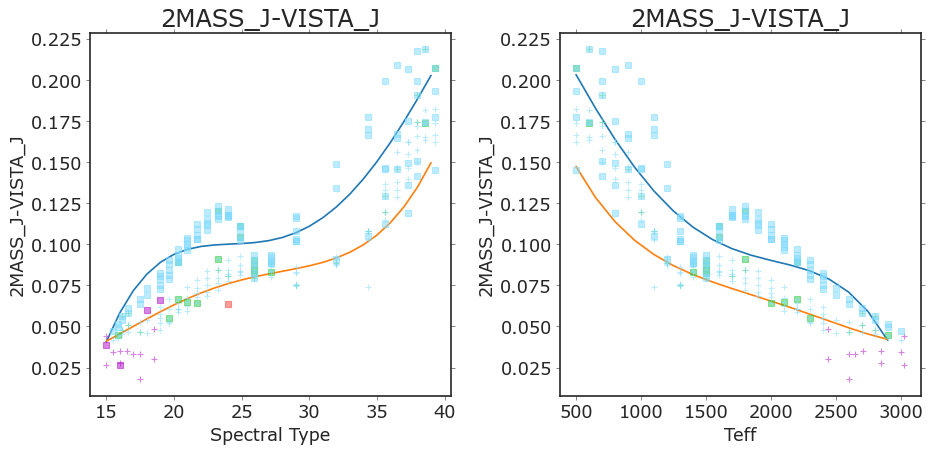

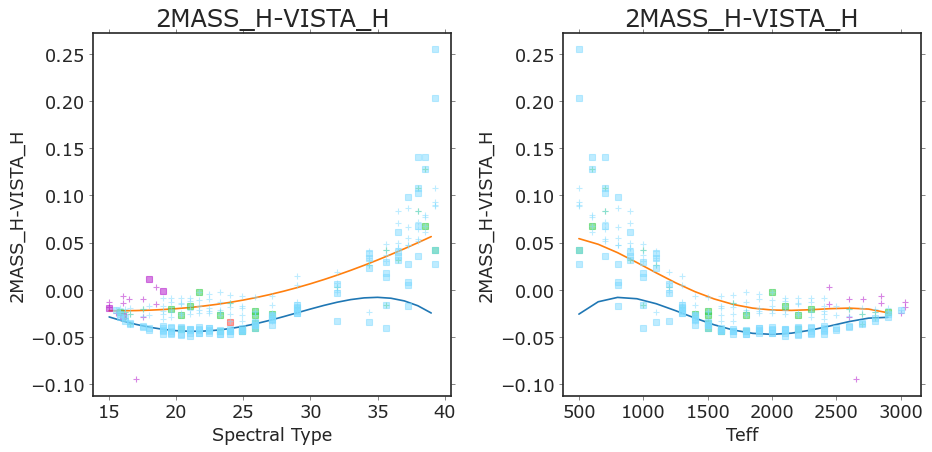

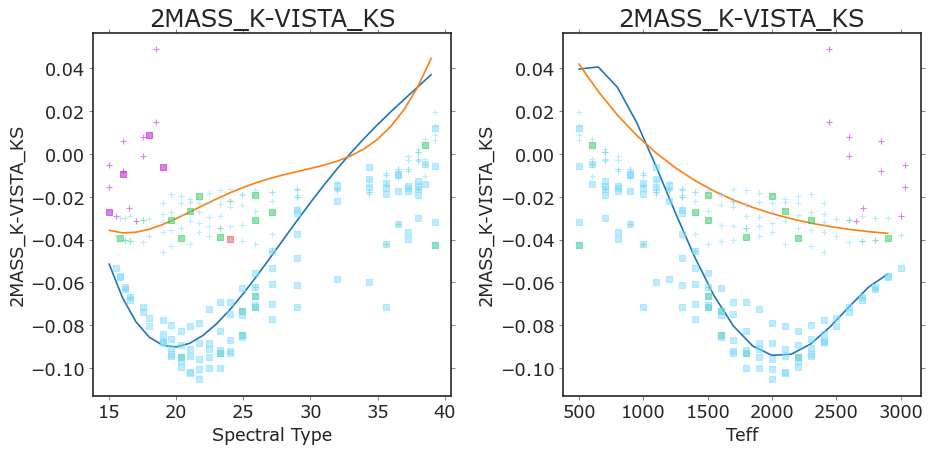

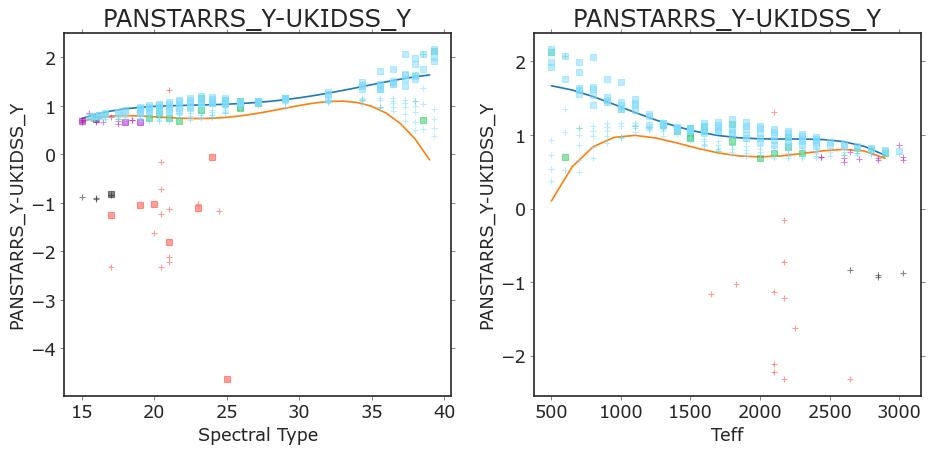

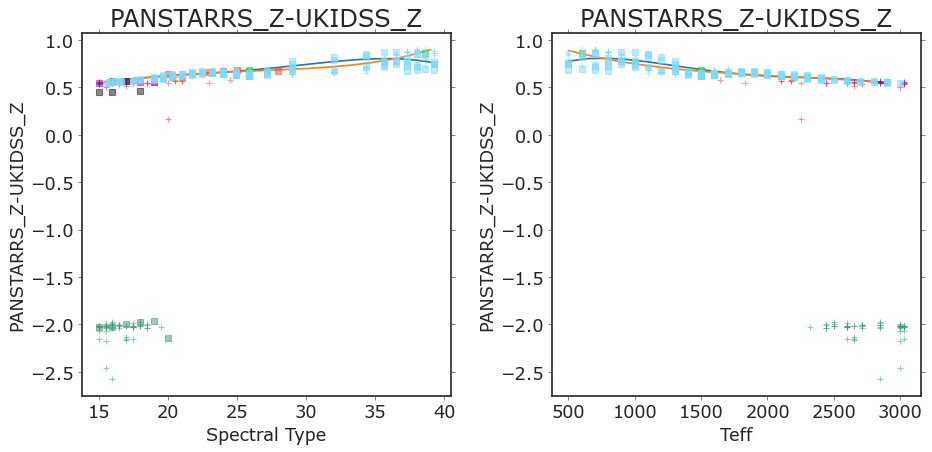

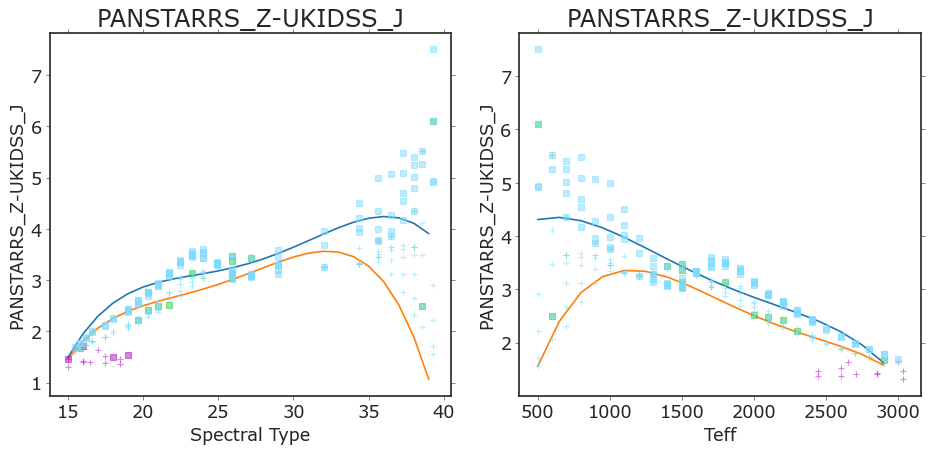

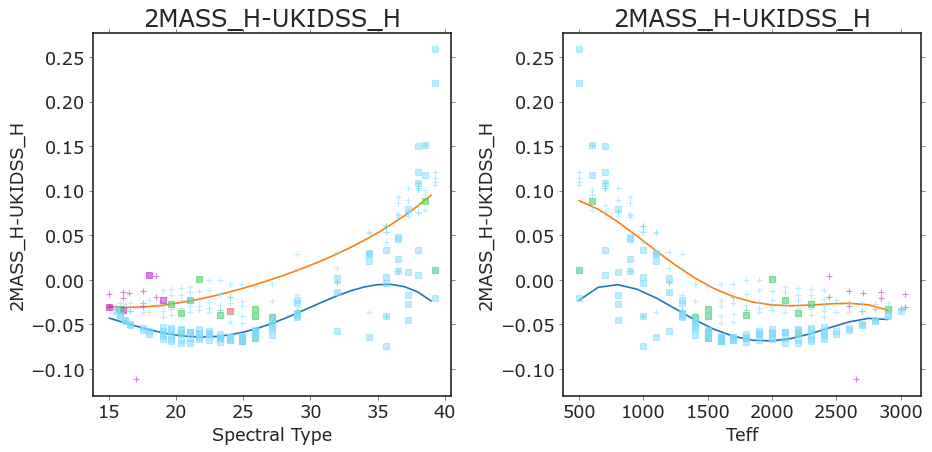

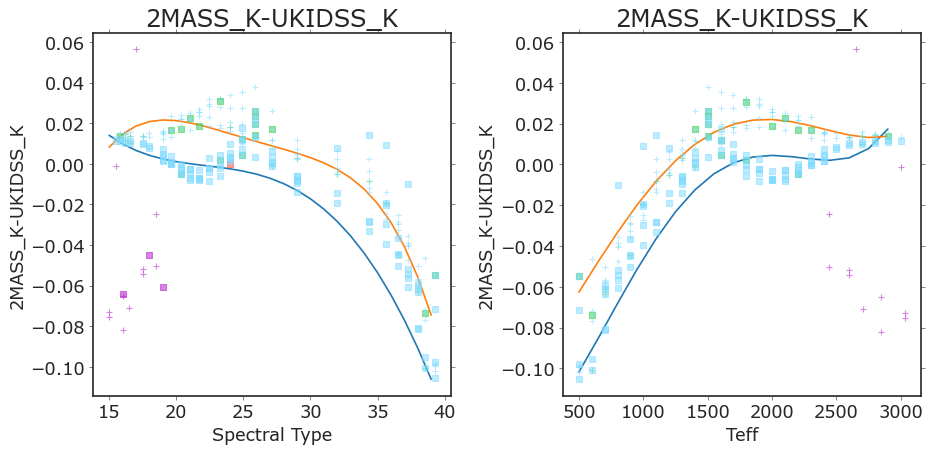

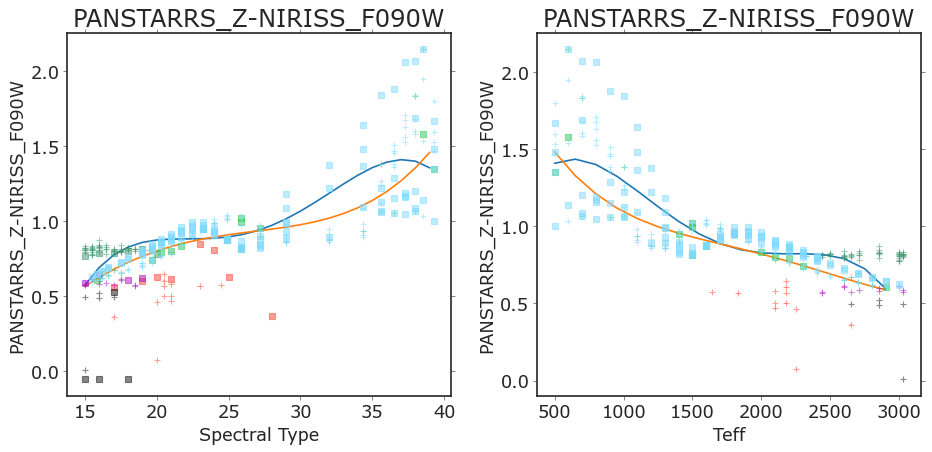

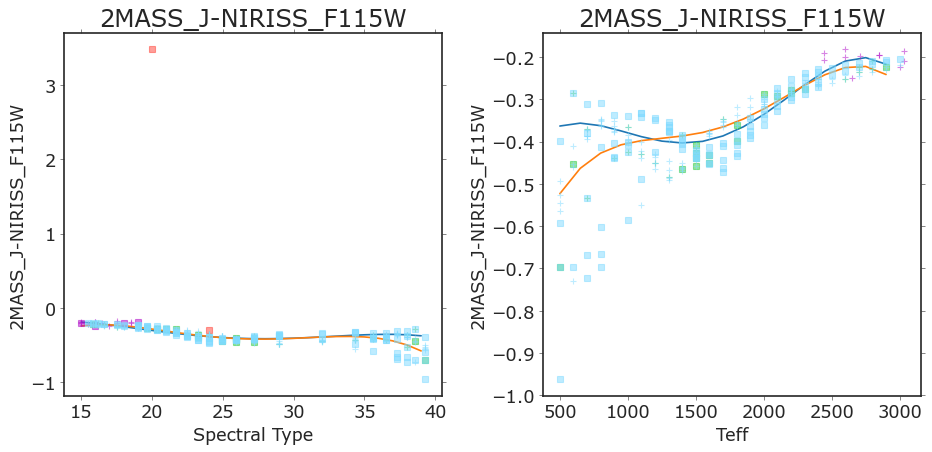

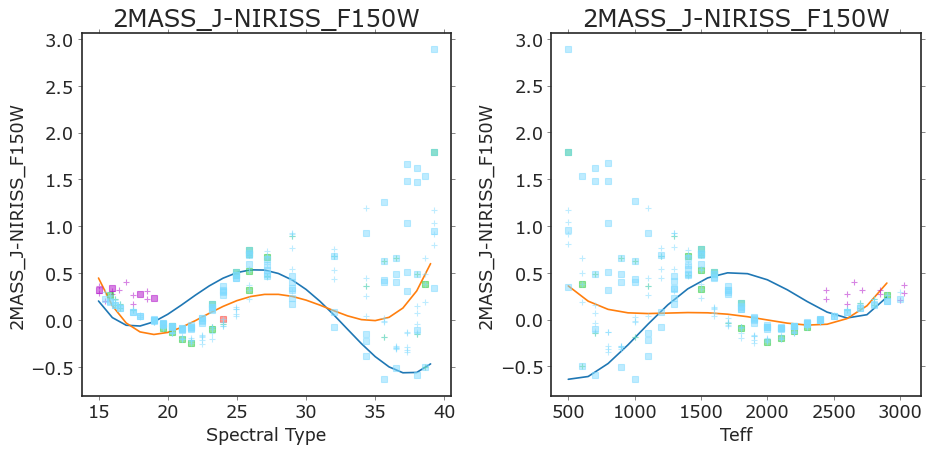

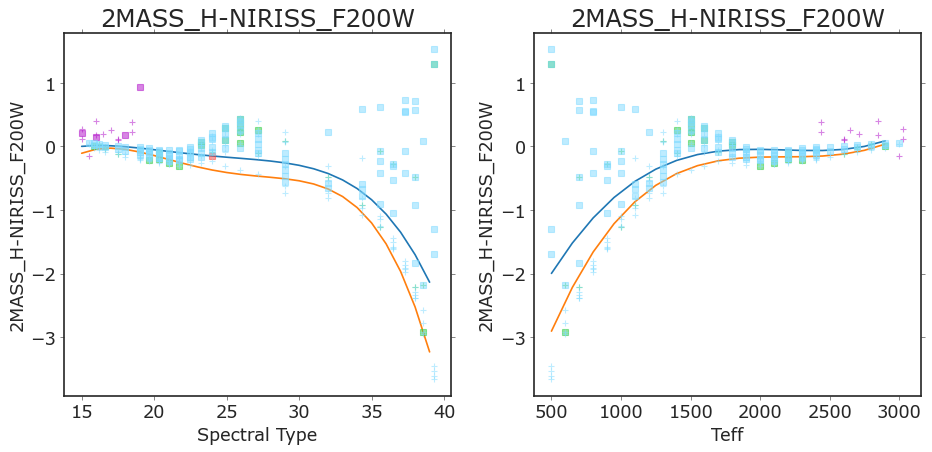

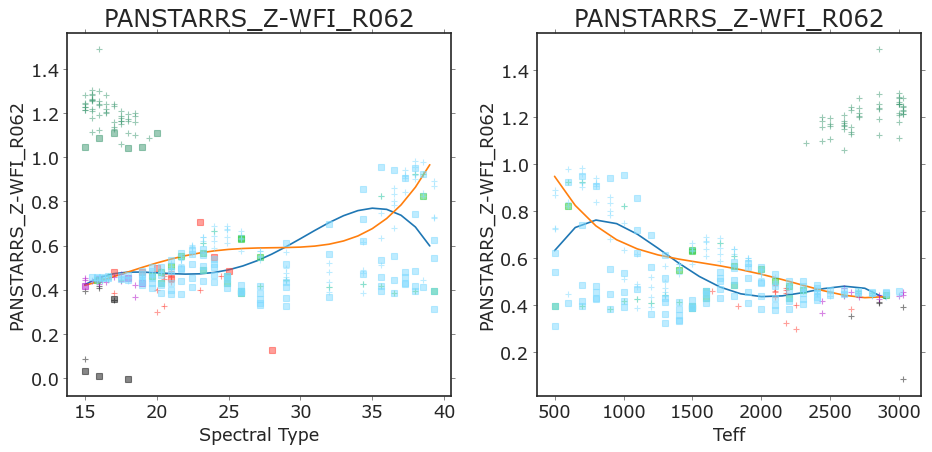

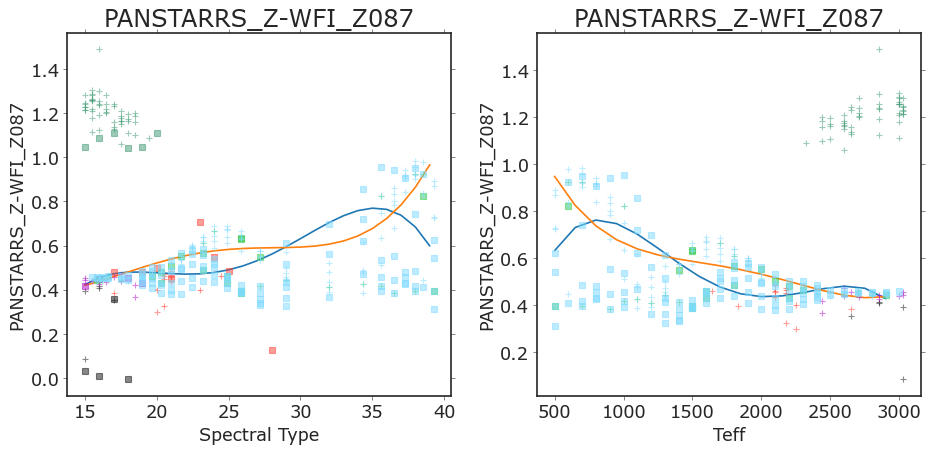

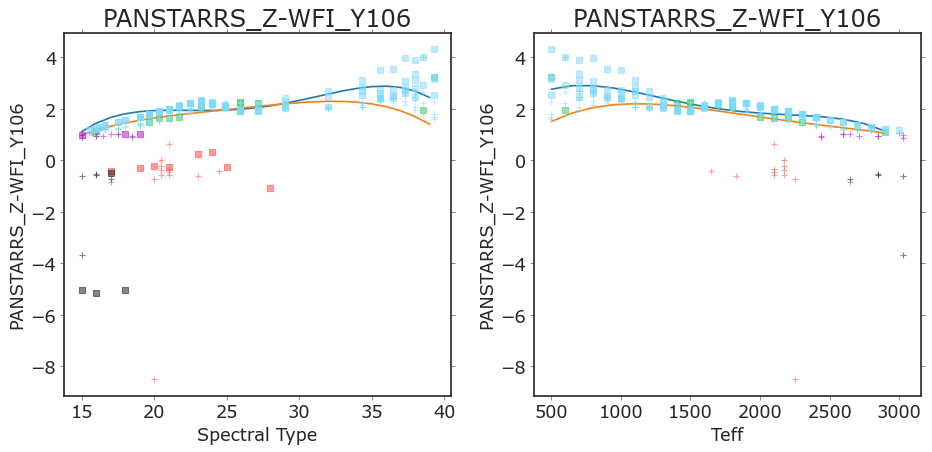

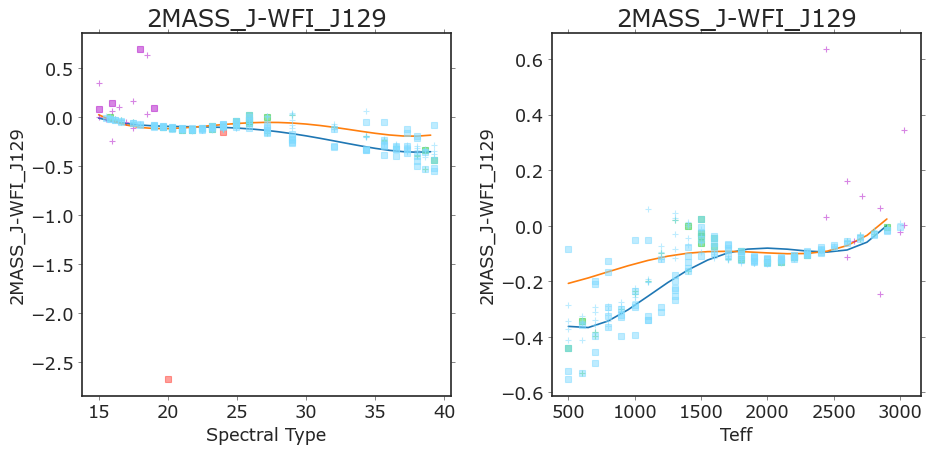

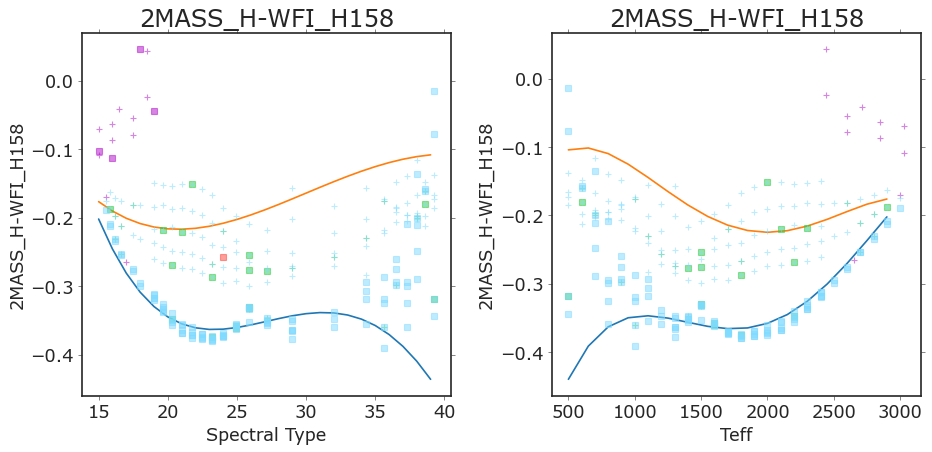

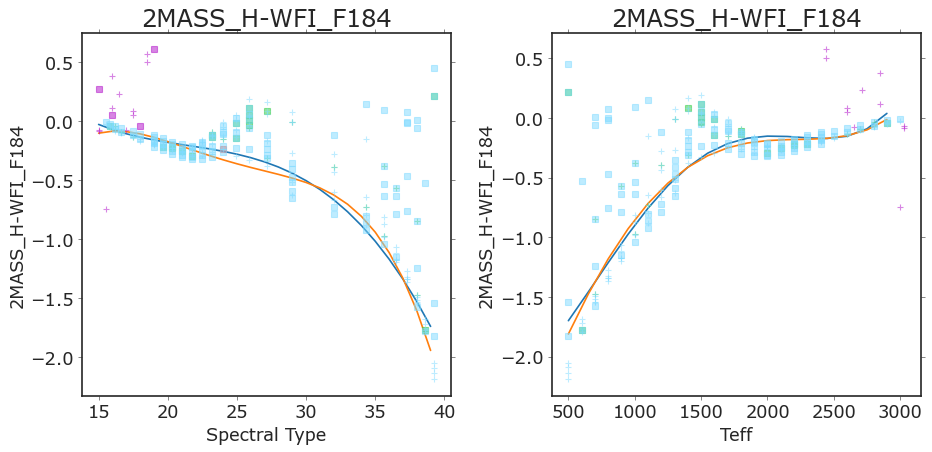

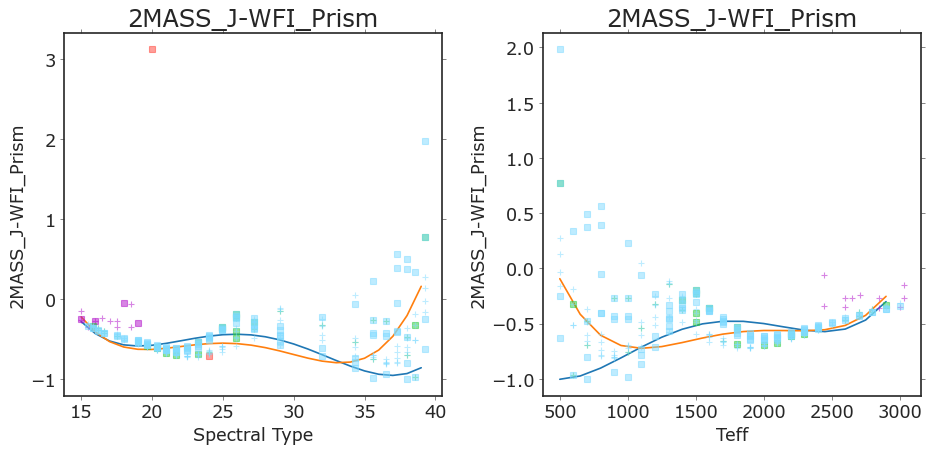

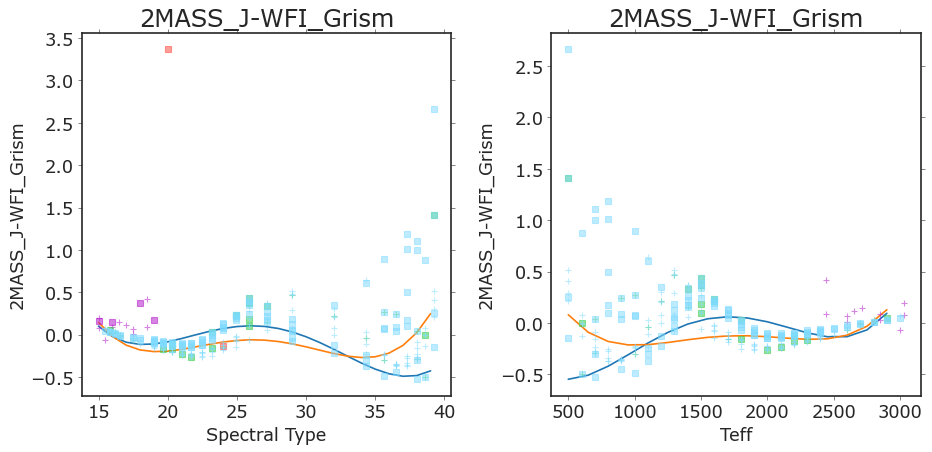

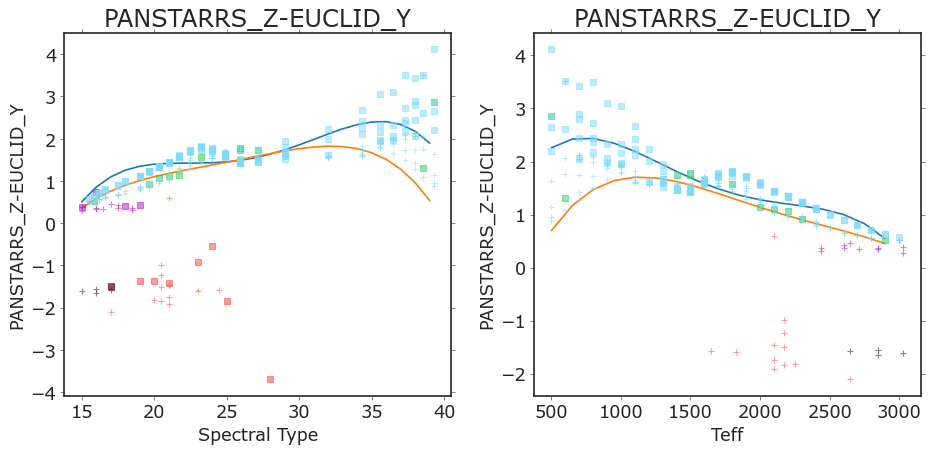

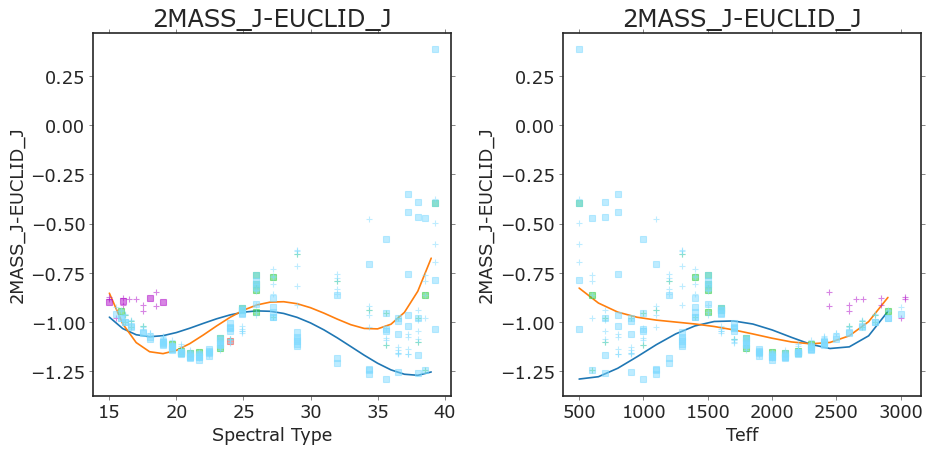

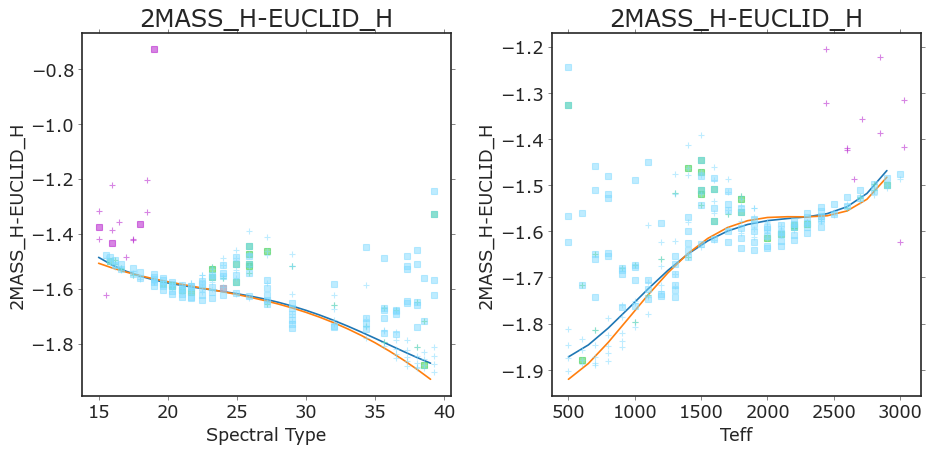

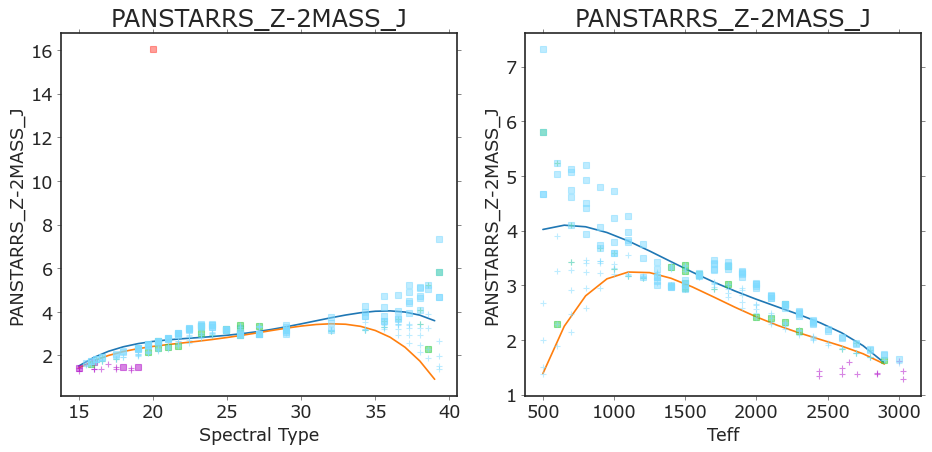

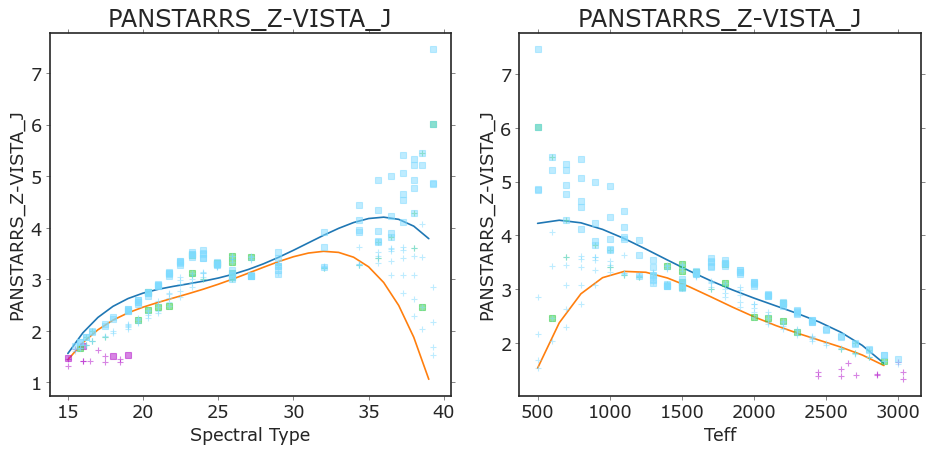

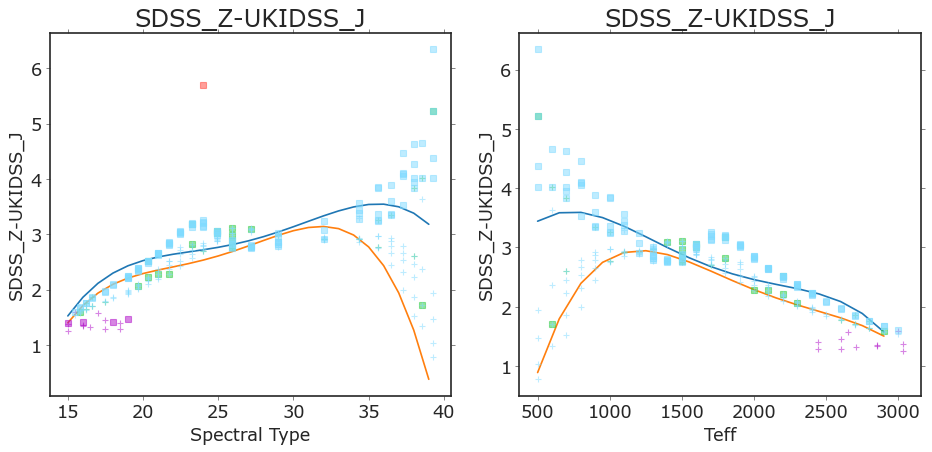

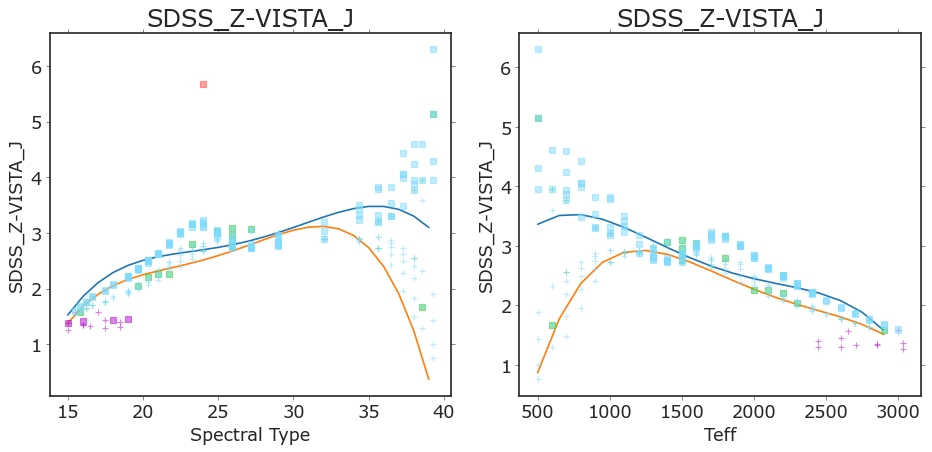

In [36]:
for k in  COLOR_TERMS:
    fig, (ax, ax1)=plt.subplots(figsize=(12, 6), ncols=2)
    
    for idx  in range(len(data)):
        
        #plot data
        mask= np.logical_and(np.vstack(data[idx][k])[:,1]>0, data[idx].subdwarf_type=='sd')

        xvyv=bin_by_spt_bin(grid, data[idx].numspt.values[mask], \
                np.vstack(data[idx][k])[:,0][mask],
                np.vstack(data[idx][k])[:,1][mask])
        ax.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                    alpha=0.5, label=labels[idx]+' sd', c=colors[idx])

        xvyv=bin_by_spt_bin(grid, data[idx].teff.values[mask], \
                np.vstack(data[idx][k])[:,0][mask],
                np.vstack(data[idx][k])[:,1][mask])
        ax1.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                     alpha=0.5, label=labels[idx]+' sd', c=colors[idx])

        #plot usd and esd
        mask= np.logical_or(data[idx].subdwarf_type =='esd', data[idx].subdwarf_type =='usd')
        ax.errorbar(data[idx].numspt[mask], np.vstack(data[idx][k])[:,0][mask], \
                    yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                    alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])
        ax1.errorbar(data[idx].teff[mask],  np.vstack(data[idx][k])[:,0][mask], \
                    yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                     alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])



    ax1.set(title=k.replace('and', '-'), xlabel='Teff', ylabel=k.replace('and', '-'))
    ax.set(title=k.replace('and', '-'), xlabel='Spectral Type', ylabel=k.replace('and', '-'))
    
    #plt.colorbar(im)
    xkey=k.split('and')[0]
    ykey=k.split('and')[1]
    
   
    plot_model_colors(sdmodel_df_line, -0.5, ax, ax1, k, {'alpha': 0.5, 
                                                                  'label': 'LowZ=-0.5',
                                                                   'fmt': 's',
                                                                  'c': '#2ECC40' })
    
    plot_model_colors(sdmodel_df_line, -1.5, ax, ax1, k, {'alpha': 0.5, 
                                                                  'label': 'LowZ=-1.5',
                                                                   'fmt': '+',
                                                                  'c': '#2ECC40' })
    
    
    plot_model_colors(sdmodel_df_ger, -0.5, ax, ax1, k, {'alpha': 0.5, 
                                                                  'label': 'Ger=-0.5',
                                                                   'fmt': 's',
                                                                  'c': '#7FDBFF' })
    
    plot_model_colors(sdmodel_df_ger, -1.5, ax, ax1, k, {'alpha': 0.5, 
                                                                  'label': 'Ger=-1.5',
                                                                   'fmt': '+',
                                                                  'c': '#7FDBFF' })
    
    plt.tight_layout()
    
 
    

    
    #fit subdwarfs
    #tot_sd_mask= 
    
    conct_data= pd.concat(data)
    conct_models= pd.concat([sdmodel_df_ger, sdmodel_df_line])
    #sorry remove data
    
    #sd_teffs= np.concatenate([conct_data.query("subdwarf_type =='sd'").teff.values, \
    sd_teffs=       conct_models.query('z==-0.5').teff.values
    #sd_spts=np.concatenate([conct_data.query("subdwarf_type =='sd'").numspt.values, \
    sd_spts=      conct_models.query('z==-0.5').spt.values
    #sd_vals=np.concatenate([np.vstack(conct_data.query("subdwarf_type =='sd'")[c].values)[:,0], \
    sd_vals=            (conct_models.query('z==-0.5')[xkey]-conct_models.query('z==-0.5')[ykey]
                              ).values
    
    #sd_vals_er#=np.concatenate([np.vstack(conct_data.query("subdwarf_type =='sd'")[c].values)[:,1], \
    sd_vals_er=         np.ones_like(conct_models.query('z==-0.5')[xkey])*0.001
    
    t= np.arange(500, 3000, 150)
    ys=np.array(bin_by_spt_bin(t,sd_teffs, sd_vals, sd_vals_er))
    y, yerr= ys[:,0], ys[:,1]
    mask2= np.logical_or.reduce([np.isnan(t), np.isnan(y), np.isnan(yerr)])
    _, fit2= fit_with_nsigma_clipping(t[~mask2], y[~mask2], yerr[~mask2], 4, sigma=5)
    #fit2= fit_spline_nsigma_clipping(t[~mask2][np.argsort(t[~mask2])], y[~mask2][np.argsort(t[~mask2])],\
    #                     yerr[~mask2][np.argsort(t[~mask2])], sigma=5)
    m2= np.nanmedian(yerr)
    ax1.plot(t, fit2(t))
    
    x=np.arange(15, 40)
    ys=np.array(bin_by_spt_bin(x,sd_spts, sd_vals, sd_vals_er))
    y, yerr= ys[:,0], ys[:,1]
    mask= np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    _, fit= fit_with_nsigma_clipping(x[~mask], y[~mask], yerr[~mask], 4, sigma=5)
    #fit= fit_spline_nsigma_clipping(x[~mask][np.argsort(x[~mask])], y[~mask][np.argsort(x[~mask])],\
    #                     yerr[~mask][np.argsort(x[~mask])], sigma=5)
    m=np.nanmedian(yerr)
    ax.plot(x, fit(x))
    
    
    scatter= np.nanmedian(yerr)
    scatter2= np.nanmedian(yerr)



    FITS['colors_spt']['subdwarfs'].update({k: {'x': 'spt',
                                          'y': k,
                                          'fit':fit,\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(x[~mask]),\
                                                     np.nanmax(x[~mask])), \
                                         'x0':0.}})

    FITS['colors_teff']['subdwarfs'].update({k: {'x': 'teff',
                                          'y': k,
                                          'fit':fit2,\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(t[~mask2]),\
                                                     np.nanmax(t[~mask2])), \
                                         'x0':0.}})
    
    
    sd_mask=np.logical_or(conct_data["subdwarf_type"]=='esd', conct_data["subdwarf_type"]=='usd')
    #sd_teffs= np.concatenate([conct_data[sd_mask].teff.values, \
    sd_teffs=     conct_models.query('z==-1.5').teff.values
    #sd_spts=np.concatenate([conct_data[sd_mask].numspt.values, \
    sd_spts=            conct_models.query('z==-1.5').spt.values
    #sd_vals=np.concatenate([np.vstack(conct_data[sd_mask][c].values)[:,0], \
    sd_vals= (conct_models.query('z==-1.5')[xkey]-conct_models.query('z==-1.5')[ykey]
                              ).values
    
    #sd_vals_er=np.concatenate([np.vstack(conct_data[sd_mask][c].values)[:,1], \
    sd_vals_er=         np.ones_like(conct_models.query('z==-1.5')[xkey])*0.001
    

    ys=np.array(bin_by_spt_bin(t,sd_teffs, sd_vals, sd_vals_er))
    y, yerr= ys[:,0], ys[:,1]
    #print (y, sd_vals, sd_teffs)
    mask2= np.logical_or.reduce([np.isnan(t), np.isnan(y), np.isnan(yerr)])
    _, fit2= fit_with_nsigma_clipping(t[~mask2], y[~mask2], yerr[~mask2], 4, sigma=5)
    #fit2= fit_spline_nsigma_clipping(t[~mask2][np.argsort(t[~mask2])], y[~mask2][np.argsort(t[~mask2])],\
    #                     yerr[~mask2][np.argsort(t[~mask2])], sigma=5)
    m2= np.nanmedian(yerr)
    ax1.plot(t, fit2(t))
    
    ys=np.array(bin_by_spt_bin(x,sd_spts, sd_vals, sd_vals_er))
    y, yerr= ys[:,0], ys[:,1]
    mask= np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    _, fit= fit_with_nsigma_clipping(x[~mask], y[~mask], yerr[~mask], 4, sigma=5)
    #fit= fit_spline_nsigma_clipping(x[~mask][np.argsort(x[~mask])], y[~mask][np.argsort(x[~mask])],\
    #                     yerr[~mask][np.argsort(x[~mask])], sigma=5)
    m=np.nanmedian(yerr)
    ax.plot(x, fit(x))
    
    
    scatter= np.nanmedian(yerr)
    scatter2= np.nanmedian(yerr)



    FITS['colors_spt']['esd'].update({k: {'x': 'spt',
                                          'y': k,
                                          'fit':fit,\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(x[~mask]),\
                                                     np.nanmax(x[~mask])), \
                                         'x0':0.}})

    FITS['colors_teff']['esd'].update({k: {'x': 'teff',
                                          'y': k,
                                          'fit':fit2,\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(t[~mask2]),\
                                                     np.nanmax(t[~mask2])), \
                                         'x0':0.}})
    
    plt.savefig('../figures/color_relations_sd{}.jpeg'.format(k), bbox_inches='tight')



In [37]:
#zhang_abs_mags_tables.columns


In [38]:
def get_abs_mags(m, merr, p, perr):
    ds= 1000/np.random.normal(p, perr, 1000)
    ms= np.random.normal(m, merr, 1000)
    res= ms-5*np.log10(ds/10.0)
    return np.nanmedian(res), np.nanstd(res)

In [39]:
#first compute SDSS_ABS_MAGS
for k in 'ugrizy':
    for sur in ['SDSS', 'PS1_PSF']:
        m=abs_mags_tables['{}_{}'.format(sur, k)].values.astype(float)
        merr=abs_mags_tables['{}_{}_er'.format(sur, k)].values.astype(float)
        p=abs_mags_tables['parallax (mas)'].values.astype(float)
        perr=abs_mags_tables[ 'parallax_er (mas)'].values.astype(float)
        vs=[get_abs_mags(mx, merrx, px, perrx) for mx, merrx, px, perrx in zip(m, merr, p, perr)]
        absm=np.vstack(vs)[:,0]
        absmerr=np.vstack(vs)[:,1]

        abs_mags_tables['abs_{}_{}'.format(sur, k)]= absm
        abs_mags_tables['abs_{}_{}_er'.format(sur, k)]= absmerr

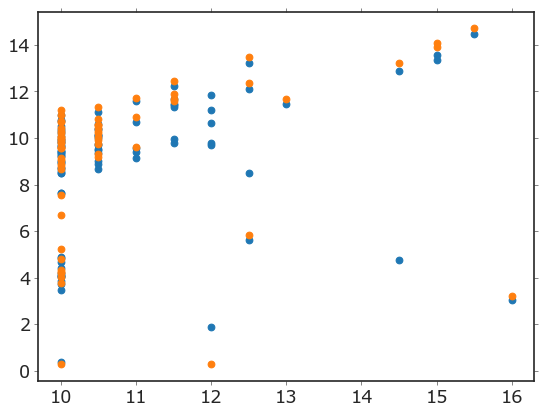

In [40]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_g)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_g)

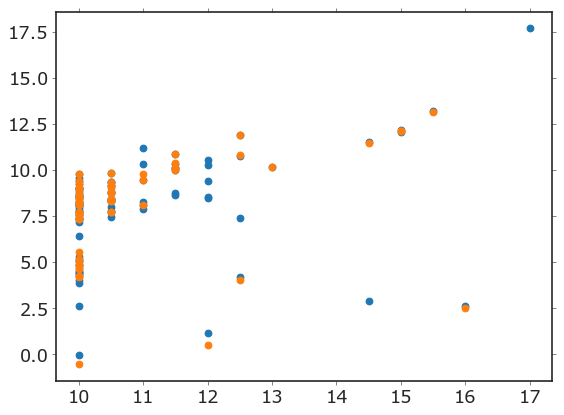

In [41]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_r)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_r)
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)

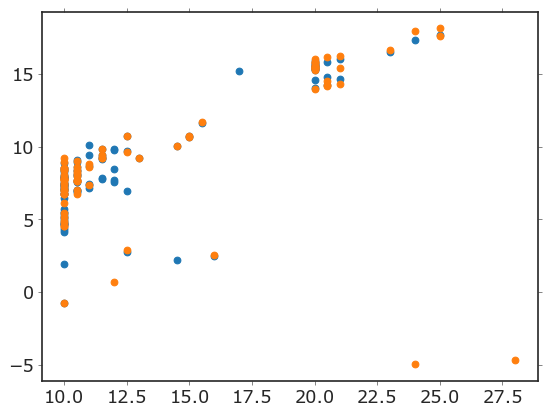

In [42]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_i)

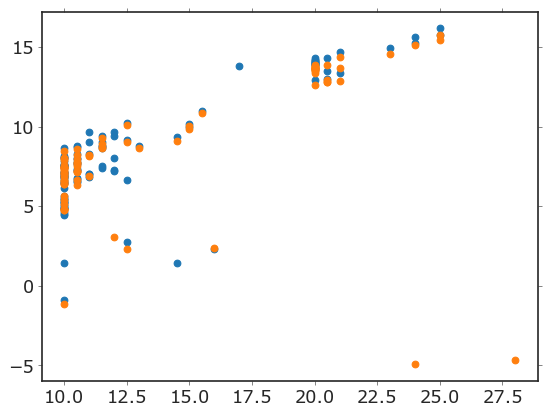

In [43]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_z)

In [44]:
COLOR_TERMS

['SDSS_GandLSST_G',
 'SDSS_RandLSST_R',
 'SDSS_IandLSST_I',
 'SDSS_ZandLSST_Z',
 'PANSTARRS_RandLSST_R',
 'PANSTARRS_IandLSST_I',
 'PANSTARRS_ZandLSST_Z',
 'PANSTARRS_YandLSST_Y',
 'LSST_GandLSST_R',
 'LSST_RandLSST_Z',
 'LSST_IandLSST_Z',
 'PANSTARRS_ZandVISTA_Z',
 'PANSTARRS_YandVISTA_Y',
 '2MASS_JandVISTA_J',
 '2MASS_HandVISTA_H',
 '2MASS_KandVISTA_KS',
 'PANSTARRS_YandUKIDSS_Y',
 'PANSTARRS_ZandUKIDSS_Z',
 'PANSTARRS_ZandUKIDSS_J',
 '2MASS_HandUKIDSS_H',
 '2MASS_KandUKIDSS_K',
 'PANSTARRS_ZandNIRISS_F090W',
 '2MASS_JandNIRISS_F115W',
 '2MASS_JandNIRISS_F150W',
 '2MASS_HandNIRISS_F200W',
 'PANSTARRS_ZandWFI_R062',
 'PANSTARRS_ZandWFI_Z087',
 'PANSTARRS_ZandWFI_Y106',
 '2MASS_JandWFI_J129',
 '2MASS_HandWFI_H158',
 '2MASS_HandWFI_F184',
 '2MASS_JandWFI_Prism',
 '2MASS_JandWFI_Grism',
 'PANSTARRS_ZandEUCLID_Y',
 '2MASS_JandEUCLID_J',
 '2MASS_HandEUCLID_H',
 'PANSTARRS_Zand2MASS_J',
 'PANSTARRS_ZandVISTA_J',
 'SDSS_ZandUKIDSS_J',
 'SDSS_ZandVISTA_J']

In [45]:
#add 2MASS magnitudes forgotten from will best
best_sample['source_name']=best_sample['Name'].apply(lambda x: "".join(x.split()))
#best_sample['sptype']= best_sample.spt.apply(splat.typeToNum)
best_sample_smol=best_sample[['source_name', 'SpTopt','Topt','SpTnir', 'Tnir','use_2MASS J','use_2MASS H','use_2MASS K','SpT', '2MASS J', '2MASS H', '2MASS K', '2MASS J_er', '2MASS H_er', '2MASS K_er']]

In [46]:
mag_columns0=np.concatenate([['SDSS_'+x for x in 'G R I Z'.split()],
                          ['PANSTARRS_'+x for x in 'R I Z Y'.split()],
                        ['LSST_'+x for x in 'G R I Z Y'.split()],
                        ['VISTA_'+x for x in 'Z Y J H KS'.split()],
                        ['UKIDSS_'+x for x in 'Y J H K'.split()],
                        ['2MASS J', '2MASS H', '2MASS K'],
                        ['NIRISS_'+x for x in 'F115W F200W F150W'.split()],
                        ['WFI_'+x for x in 'R062 Z087 Y016 J129 H158 F184 Prism Grism'.split()],
                        ['EUCLID_'+x for x in 'Y J H'.split()]])

mag_columns=np.concatenate([mag_columns0, [x+'_er' for x in mag_columns0]] )

old_names=np.concatenate([['abs_SDSS_'+x for x in 'g r i z'.split()],
                          ['abs_PS1_PSF_'+x for x in 'r i z y'.split()]])

old_names= np.concatenate([old_names, [x+'_er' for x in old_names]])

new_names=np.concatenate([['SDSS_'+x.upper() for x in 'g r i z'.split()],
                          ['PANSTARRS_'+x.upper() for x in 'r i z y'.split()]])

new_names= np.concatenate([new_names, [x+'_er' for x in new_names]])

In [47]:
#either simbad or will best spectral type
def get_spt_from_simbad(row):
    spt=row.simbad_type
    if (str(spt))=='nan':
        spt= row.sptype
    return splat.typeToNum(spt)

In [48]:
str(abs_mags_tables.simbad_type.iloc[0])

'nan'

In [49]:
abs_mags_tables['spt']=abs_mags_tables.apply(get_spt_from_simbad, axis=1)

In [50]:
#sd_models=pd.concat([sdmodel_df_ger, sdmodel_df_line]).query('z==-0.5')
#esd_models=pd.concat([sdmodel_df_ger, sdmodel_df_line]).query('z==-1.5')
sdmodel_df_ger['spt']=sdmodel_df_ger.teff.apply(lambda x: teff_to_spt_pec(x, sd=True))
sd_models= sdmodel_df_ger.query('z==-0.5')
esd_models= sdmodel_df_ger.query('z==-1.5')


for c in mag_columns:
    sd_models[c+'_er']=0.01
    esd_models[c+'_er']=0.01

In [51]:
#get splat subdwarfs
#sd=splat.get

In [52]:
sd_table= pd.concat([abs_mags_tables.query("subdwarf_type=='sd'"),
                     best_sample_smol[np.logical_and(np.logical_or(best_sample_smol.SpT.str.contains('sd'),
            best_sample_smol.SpTopt.str.contains('sd')),
            ~best_sample_smol.SpTopt.str.contains('esd'))]]).rename(columns=dict(zip(old_names, new_names)))
#sd_table.sptype= sd_table.sptype.apply(splat.typeToNum)
esd_table= pd.concat([abs_mags_tables.query("subdwarf_type=='esd'"),
                     best_sample_smol[np.logical_or(best_sample_smol.SpT.str.contains('esd'),
            best_sample_smol.SpTopt.str.contains('esd'))]]).rename(columns=dict(zip(old_names, new_names)))
#esd_table.sptype= esd_table.sptype.apply(splat.typeToNum)

In [53]:
#missing
missing=['LSST_G', 'LSST_R', 'LSST_I', 'LSST_Z', 'LSST_Y', \
         '2MASS_J', '2MASS_H', '2MASS_K', 'VISTA_Z', 'VISTA_Y', \
         'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K']
missing= np.concatenate([missing, np.concatenate([['NIRISS_'+x for x in 'F115W F200W F150W'.split()],
                        ['WFI_'+x for x in 'R062 Z087 Y106 J129 H158 F184 Prism Grism'.split()],
                        ['EUCLID_'+x for x in 'Y J H'.split()]])])
missing

array(['LSST_G', 'LSST_R', 'LSST_I', 'LSST_Z', 'LSST_Y', '2MASS_J',
       '2MASS_H', '2MASS_K', 'VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H',
       'VISTA_KS', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K',
       'NIRISS_F115W', 'NIRISS_F200W', 'NIRISS_F150W', 'WFI_R062',
       'WFI_Z087', 'WFI_Y106', 'WFI_J129', 'WFI_H158', 'WFI_F184',
       'WFI_Prism', 'WFI_Grism', 'EUCLID_Y', 'EUCLID_J', 'EUCLID_H'],
      dtype='<U12')

In [54]:
for m in missing:
    color_key= [k for k in COLOR_TERMS if m in k][0]
    print (m, color_key)
    ref_k= color_key.split('and')[0]
    if '2MASS' in ref_k:
        ref_k= ref_k.replace('2MASS_', '2MASS ')
    
    #subdwarf
    pol=np.poly1d(FITS['colors_spt']['subdwarfs'][color_key]['fit'])
    corr=pol(sd_table.spt.values)
    sd_table[m]=  sd_table[ref_k]-corr
    sd_table[m+'_er']= sd_table[ref_k+'_er']
    
    #esubdwarf
    pol=np.poly1d(FITS['colors_spt']['esd'][color_key]['fit'])
    corr=pol(esd_table.spt.values)
    esd_table[m]=  esd_table[ref_k]-corr
    esd_table[m+'_er']= esd_table[ref_k+'_er']

LSST_G SDSS_GandLSST_G
LSST_R SDSS_RandLSST_R
LSST_I SDSS_IandLSST_I
LSST_Z SDSS_ZandLSST_Z
LSST_Y PANSTARRS_YandLSST_Y
2MASS_J 2MASS_JandVISTA_J
2MASS_H 2MASS_HandVISTA_H
2MASS_K 2MASS_KandVISTA_KS
VISTA_Z PANSTARRS_ZandVISTA_Z
VISTA_Y PANSTARRS_YandVISTA_Y
VISTA_J 2MASS_JandVISTA_J
VISTA_H 2MASS_HandVISTA_H
VISTA_KS 2MASS_KandVISTA_KS
UKIDSS_Y PANSTARRS_YandUKIDSS_Y
UKIDSS_J PANSTARRS_ZandUKIDSS_J
UKIDSS_H 2MASS_HandUKIDSS_H
UKIDSS_K 2MASS_KandUKIDSS_K
NIRISS_F115W 2MASS_JandNIRISS_F115W
NIRISS_F200W 2MASS_HandNIRISS_F200W
NIRISS_F150W 2MASS_JandNIRISS_F150W
WFI_R062 PANSTARRS_ZandWFI_R062
WFI_Z087 PANSTARRS_ZandWFI_Z087
WFI_Y106 PANSTARRS_ZandWFI_Y106
WFI_J129 2MASS_JandWFI_J129
WFI_H158 2MASS_HandWFI_H158
WFI_F184 2MASS_HandWFI_F184
WFI_Prism 2MASS_JandWFI_Prism
WFI_Grism 2MASS_JandWFI_Grism
EUCLID_Y PANSTARRS_ZandEUCLID_Y
EUCLID_J 2MASS_JandEUCLID_J
EUCLID_H 2MASS_HandEUCLID_H


In [55]:

sd_table[['source_name', 'SDSS_G', 'simbad_type', 'spt']].dropna()

source_name     SDSS_G simbad_type   spt
29                  V* V470 Cam   4.260991      sdB+dM  10.0
33                SBSS 1643+516   7.542913     sdO+dMe  10.0
157         CTI 000351.3+280138  10.301668        sdM0  10.0
160         CTI 225431.2+280046  11.199963       sdM0:  10.0
203                      Ton 74   4.221149      sdB+dM  10.0
273                FBS 1531+381   5.239779      sdB+dM  10.0
290  LAMOST J003836.41+403658.6   9.042137     sdM0.0+  10.0
291                HS 2231+2441   3.774087      sdB+dM  10.0
363                 PG 1621+476   4.313018      sdB+dM  10.0
366     2MASS J00483645+0009316  13.917002      sdM5.0  15.0
413     2MASS J23465986-0059438   9.574414      sdM0.0  10.0
424             GSC 00196-00617   4.042187      sdB+dM  10.0
425       ATO J291.5394+37.3356   6.708541      sdB+dM  10.0
426    SDSS J192715.88+380808.2   4.800110      sdB+dM  10.0
434              TYC 1887-376-1   0.285320        sdM2  12.0
449               HAT 163-12247   9.954469      sdM0.0  10.0
455     2MASS J00480004+0028493  10.884441      sdM1.0  11.0
461    SDSS J214607.41+741128.9  11.715864        sdM1  11.0
462     2MASS J00512569-0037167  11.901537      sdM1.5  11.5
499     2MASS J06050606+2338119  10.686182      sdM0.0  10.0
501     2MASS J00395315+4118563  10.416564     sdM0.5+  10.5
502     2MASS J00524098+3956252   9.730037     sdM0.5+  10.5
503     2MASS J00540029+4048316  10.804922     sdM0.5+  10.5
505     2MASS J01091433+4312361  10.029137     sdM0.0+  10.0
508     2MASS J02495423+3321174   9.817990     sdM0.0+  10.0
509     2MASS J02534212+3237193  10.973472      sdM0.0  10.0
511     2MASS J02580917+3649542  13.485006     sdM2.5+  12.5
512     2MASS J03005723+3459385  11.668526     sdM1.5+  11.5
514     2MASS J02530869+3627420   9.614850     sdM1.0-  11.0
521     2MASS J08220770+5556454  11.658177     sdM3.0-  13.0
522     2MASS J08224111+5614588  10.221361     sdM0.0+  10.0
523     2MASS J06005109+2145305  10.282755     sdM0.5+  10.5
524     2MASS J08182967+5430124  12.361323     sdM2.5+  12.5
525     2MASS J08134516+0057426   9.802654     sdM0.0+  10.0
526     2MASS J00561912+4126363  12.463822     sdM1.5+  11.5
530     2MASS J06054641+2425503   9.916355     sdM0.5+  10.5
532     2MASS J08192949+5719225  10.027441      sdM0.5  10.5
533     2MASS J02573193+3704592   5.820645     sdM2.5+  12.5
537     2MASS J02511587+3545321   9.608094     sdM0.0-  10.0
543  LAMOST J055702.99+222859.4   9.313173     sdM0.5+  10.5
545     2MASS J06092363+2324016   9.145752     sdM0.0+  10.0
546     2MASS J01054044+4355293  10.717468      sdM0.0  10.0
548     2MASS J01142610+4651192   9.189834     sdM0.5+  10.5
549     2MASS J08181694+5739571  10.217612     sdM0.5+  10.5
584    SDSS J111929.19+672104.0  14.080206  sdM5.0-5.5  15.0
585     2MASS J14343406+3841046  14.704710      sdM5.5  15.5
617     2MASS J10162654+0241069   3.191528      sdM6.0  16.0
629     2MASS J00053086+0317358   8.809721        sdM0  10.0
637     2MASS J06233465+2656440  10.567403      sdM0.5  10.5
640            UCAC4 715-046846  11.342351      sdM0.5  10.5
641            UCAC4 444-047525   9.578103        sdM0  10.0
647            UCAC4 588-048087   8.889764        sdM0  10.0
653            UCAC4 567-050335  10.415269        sdM0  10.0
667    SDSS J113433.88+124522.4  11.576055      sdM1.5  11.5

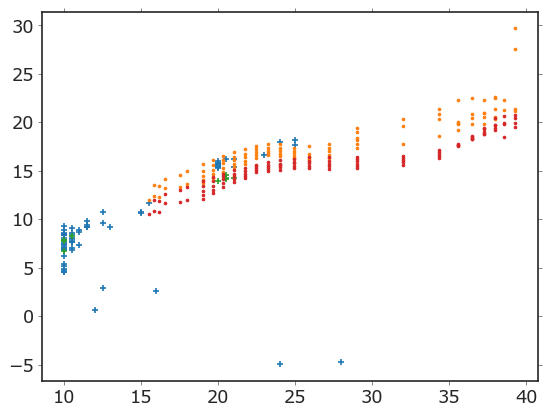

In [56]:
spt_range=[21, 23]
sc='SDSS_I'


mask_data= np.logical_and.reduce([sd_table.spt>spt_range[0], sd_table.spt<=spt_range[1], sd_table.SDSS_Z>0] )

mask_model=np.logical_and(sd_models.spt>spt_range[0], sd_models.spt<=spt_range[1])
model_scale_sd= np.nanmedian(sd_table[sc].values[mask_data])\
- np.nanmedian(sd_models[sc][mask_model].values)

spt_range=[20, 21]
mask_data= np.logical_and.reduce([esd_table.spt>spt_range[0], esd_table.spt<=spt_range[1], esd_table.SDSS_Z>0] )
mask_model=np.logical_and(esd_models.spt>spt_range[0], esd_models.spt<=spt_range[1])
model_scale_esd= np.nanmedian(esd_table[sc].values[mask_data])\
- np.nanmedian(esd_models[sc][mask_model].values)


fig, ax=plt.subplots()
ax.scatter(sd_table.spt, sd_table[sc], marker='+')
ax.scatter(sd_models.spt, sd_models[sc]+model_scale_sd, s=5)


ax.scatter(esd_table.spt, esd_table[sc], marker='+')
ax.scatter(esd_models.spt, esd_models[sc]+model_scale_esd, s=5)


#print (model_scale_esd)

SCALE_FACTORS={'esd': model_scale_esd, 'subdwarfs': model_scale_sd}

In [57]:
ABS_MAG_USED={'subdwarf': {}, 'esd': {}}

In [58]:
#mags to compute
mag_columns_to_use=np.concatenate([['SDSS_'+x for x in 'G R I Z'.split()],
                          ['PANSTARRS_'+x for x in 'R I Z Y'.split()],
                        ['LSST_'+x for x in 'G R I Z Y'.split()],
                        ['VISTA_'+x for x in 'Z Y J H KS'.split()],
                        ['UKIDSS_'+x for x in 'Y J H K'.split()],
                        ['2MASS J', '2MASS H', '2MASS K'],
                        ['NIRISS_'+x for x in 'F115W F200W F150W'.split()],
                        ['WFI_'+x for x in 'R062 Z087 Y106 J129 H158 F184 Prism Grism'.split()],
                        ['EUCLID_'+x for x in 'Y J H'.split()]])

In [59]:
mag_columns_to_use

array(['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', 'PANSTARRS_R',
       'PANSTARRS_I', 'PANSTARRS_Z', 'PANSTARRS_Y', 'LSST_G', 'LSST_R',
       'LSST_I', 'LSST_Z', 'LSST_Y', 'VISTA_Z', 'VISTA_Y', 'VISTA_J',
       'VISTA_H', 'VISTA_KS', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H',
       'UKIDSS_K', '2MASS J', '2MASS H', '2MASS K', 'NIRISS_F115W',
       'NIRISS_F200W', 'NIRISS_F150W', 'WFI_R062', 'WFI_Z087', 'WFI_Y106',
       'WFI_J129', 'WFI_H158', 'WFI_F184', 'WFI_Prism', 'WFI_Grism',
       'EUCLID_Y', 'EUCLID_J', 'EUCLID_H'], dtype='<U12')

In [60]:
#add observing logs and splat subdwarfs
obs_log_ukidss=pd.read_excel('/Volumes/LaCie/SpeX targets.xlsx', sheet_name='UKIDSS-SDSS')
obs_log_vhs=pd.read_excel('/Volumes/LaCie/SpeX targets.xlsx', sheet_name='VHS-SDSS')
obs_log_ps=pd.read_excel('/Volumes/LaCie/SpeX targets.xlsx', sheet_name='VHS-PS1')

In [61]:
list(obs_log_ps.columns)

['DESIGNATION',
 'priority',
 'OBSERVATION_DATE',
 'SPEX_TYPE',
 'SIMBAD_sp_type',
 'NOTE',
 'Jmag',
 'Kmag',
 'Hj',
 'i-J',
 'z-J',
 'J-K',
 'distance',
 'vtan',
 'SrcID',
 'RAJ2000_VHS',
 'DEJ2000_VHS',
 'Ymag_VHS',
 'e_Jmag_VHS',
 'Jperrbits_VHS',
 'MJD_VHS',
 'Epoch_VHS',
 'Hmag_VHS',
 'e__Kmag_VHS',
 'Ksperrbits_VHS',
 'Mclass_VHS',
 'objID_PS1',
 'RAJ2000_PS1',
 'DEJ2000_PS1',
 'MJD_PS1',
 'Epoch_PS1',
 'PSg',
 'ePSg',
 'gFlags',
 'PSr',
 'ePSr',
 'rFlags',
 'PSi',
 'ePSi',
 'iFlags',
 'PSz',
 'ePSz',
 'zFlags',
 'PSy',
 'ePSy',
 'yFlags',
 'Separation_VHS_PS1',
 'pmra',
 'pmdec',
 'pm_mas_VHS_PS1',
 'Hz',
 'Hjcond',
 'diffepoch',
 'ra_GaiaDR2',
 'dec_GaiaDR2',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm_GaiaDR2',
 'pmra_GaiaDR2',
 'pmra_error_GaiaDR2',
 'pmdec_GaiaDR2',
 'pmdec_error_GaiaDR2',
 'astrometric_n_good_obs_al',
 'ruwe',
 'duplicated_source',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'dr2_radial_velocity',
 'dr2_radial_velocity_er

In [62]:
for k in 'Y H'.split():
    obs_log_ukidss['UKIDSS_{}'.format(k)]=obs_log_ukidss['{}mag_LAS'.format(k)]-5*np.log10(obs_log_ukidss.distance/10)
    obs_log_ukidss['UKIDSS_{}_er'.format(k)]=obs_log_ukidss['e_{}mag_LAS'.format(k)]
    
    #vhs
    obs_log_vhs['VISTA_{}'.format(k)]=obs_log_vhs['{}mag_VHS'.format(k)]-5*np.log10(obs_log_vhs.distance/10)
    obs_log_vhs['VISTA_{}_er'.format(k)]=obs_log_vhs['e_Jmag_VHS'.format(k)]

for k in 'J K'.split():
    obs_log_ukidss['UKIDSS_{}'.format(k)]=obs_log_ukidss['{}mag'.format(k)]-5*np.log10(obs_log_ukidss.distance/10)
    obs_log_ukidss['UKIDSS_{}_er'.format(k)]=obs_log_ukidss['e_{}mag_LAS'.format(k)]
    #vhs
    obs_log_vhs['VISTA_{}'.format(k)]=obs_log_vhs['{}mag'.format(k)]-5*np.log10(obs_log_vhs.distance/10)
    obs_log_vhs['VISTA_{}_er'.format(k)]=obs_log_vhs['e_{}mag_VHS'.format(k)]

k='K'
obs_log_vhs['VISTA_KS'.format(k)]=obs_log_vhs['{}mag'.format(k)]-5*np.log10(obs_log_vhs.distance/10)
obs_log_vhs['VISTA_KS_er'.format(k)]=obs_log_vhs['e_{}mag_VHS'.format(k)]

for k in 'g r i z'.split():
    obs_log_ukidss['SDSS_{}'.format(k)]=obs_log_ukidss['SDSS{}'.format(k)]-5*np.log10(obs_log_ukidss.distance/10)
    obs_log_ukidss['SDSS_{}_er'.format(k)]=obs_log_ukidss['eSDSS{}'.format(k)]

In [63]:
observed_sdss_ukidss=obs_log_ukidss[~obs_log_ukidss['OBSERVATION_DATE'].isna()]
observed_vhs_sdss=obs_log_vhs[~obs_log_vhs['OBSERVATION_DATE'].isna()]
observed_ps=obs_log_ps[~obs_log_ps['OBSERVATION_DATE'].isna()]

In [64]:
obs_conct= pd.concat([observed_sdss_ukidss, observed_vhs_sdss, observed_ps])
obs_conct['SPEX_TYPE']=obs_conct.SPEX_TYPE.astype(str)
obs_conct_esd=obs_conct[obs_conct.SPEX_TYPE.str.contains('esd')]
obs_conct_sd=obs_conct[np.logical_and(~obs_conct.SPEX_TYPE.str.contains('esd'),
                                      obs_conct.SPEX_TYPE.str.contains('sd'))]

In [65]:
obs_conct_sd['spt']= obs_conct_sd.SPEX_TYPE.apply(splat.typeToNum)

In [66]:
obs_conct_esd

DESIGNATION  priority OBSERVATION_DATE     SPEX_TYPE  \
7    J013127.77+045925.4         0         20220116    sdM2/esdM4   
59   J110650.52+115421.0         0         20220227    esdM5/sdM4   
159  J142224.03+040436.3         0         20220227  esdM6.5/sdM5   

    SIMBAD_sp_type    Jmag    Kmag         Hj       i-J    z-J  ...  \
7              NaN  15.729  15.036  18.653067  1.968001  1.394  ...   
59             NaN  16.930  16.246  19.169338  2.140999  1.377  ...   
159            NaN  16.893  16.282  19.399701  2.116001  1.453  ...   

     phot_bp_rp_excess_factor_corrected  RAdeg_SDSSDR2  DEdeg_SDSSDR2  \
7                                   NaN            NaN            NaN   
59                                  NaN            NaN            NaN   
159                                 NaN            NaN            NaN   

    objID_SDSSDR2  mode_SDSSDR2  q_mode_SDSSDR2  class_SDSSDR2  flags  \
7             NaN           NaN             NaN            NaN    NaN   
59            NaN           NaN             NaN            NaN    NaN   
159           NaN           NaN             NaN            NaN    NaN   

     ObsDate_SDSSDR2  Q_SDSSDR2  
7                NaN        NaN  
59               NaN        NaN  
159              NaN        NaN  

[3 rows x 227 columns]

In [67]:
sd_table=sd_table.append(obs_conct_sd)

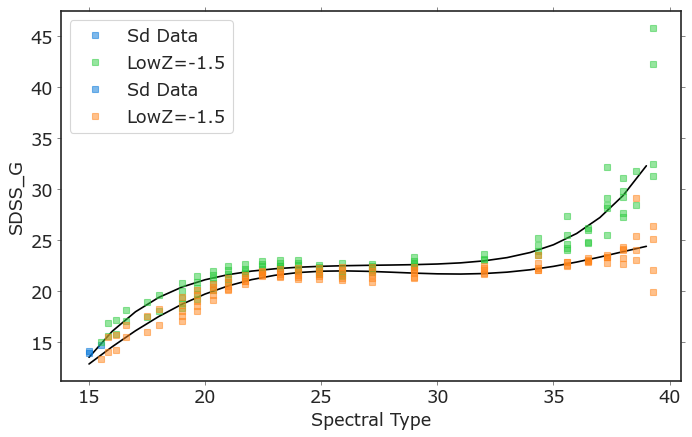

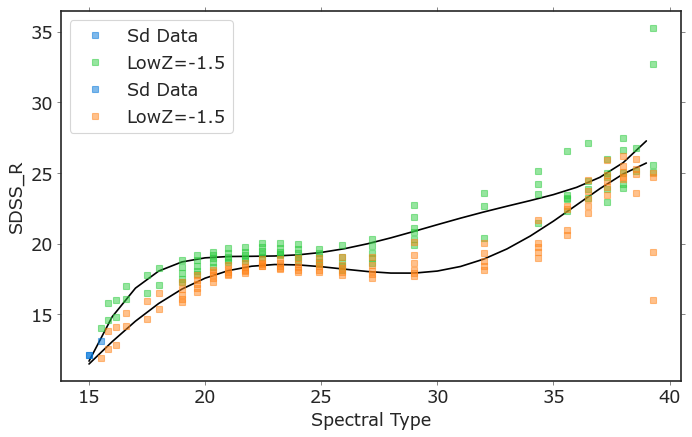

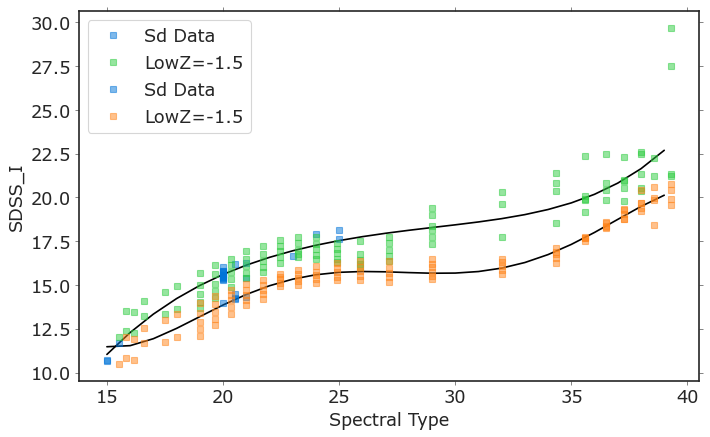

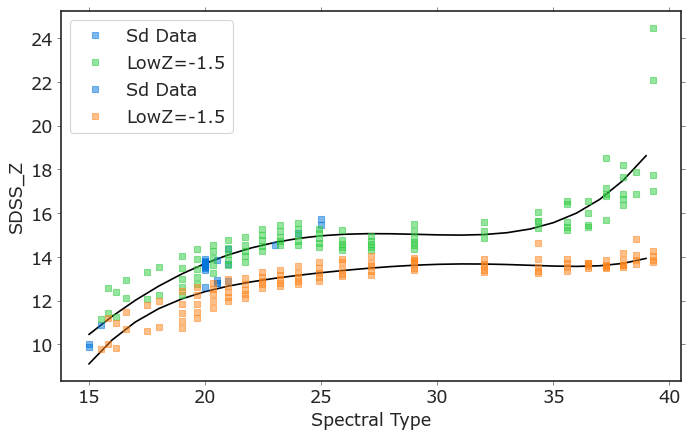

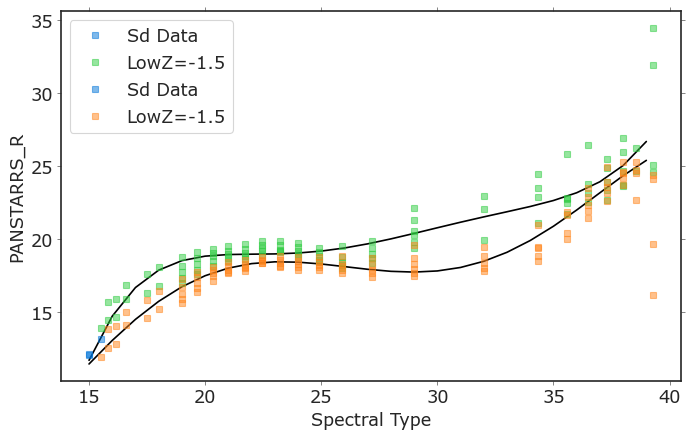

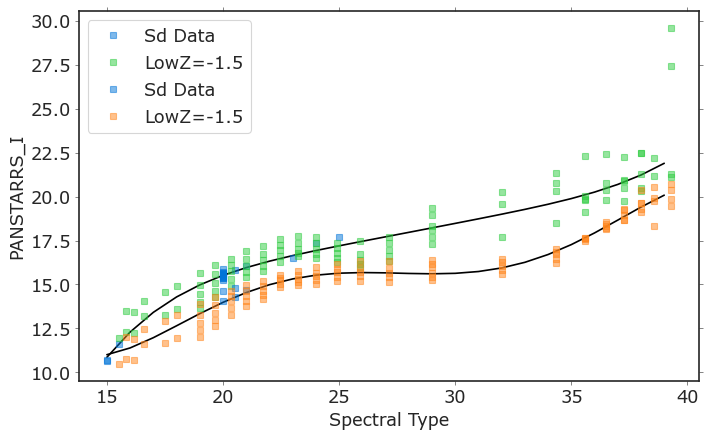

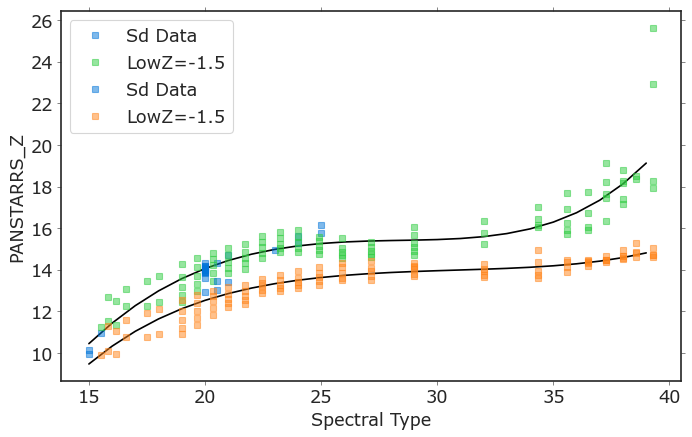

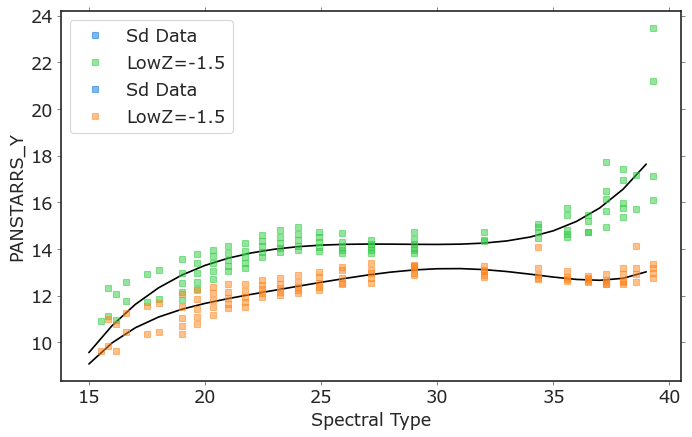

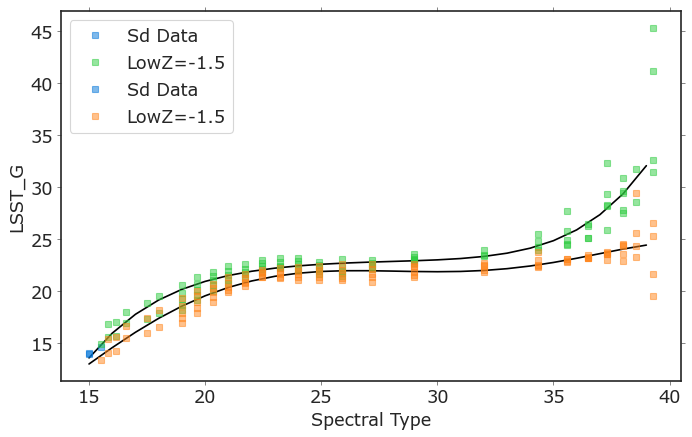

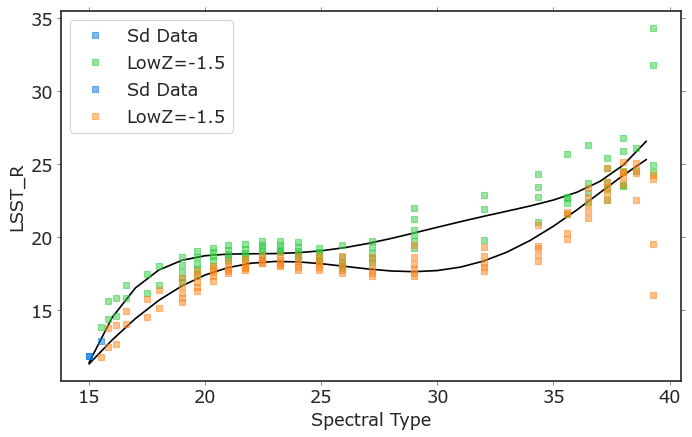

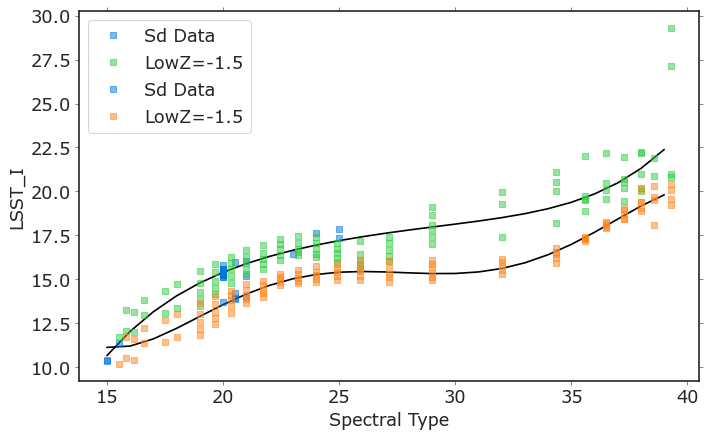

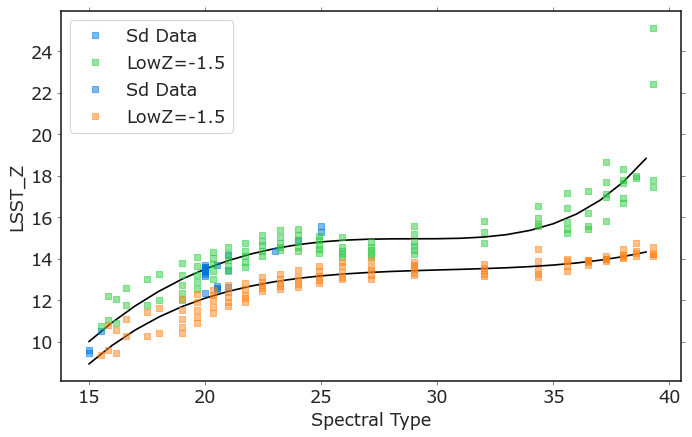

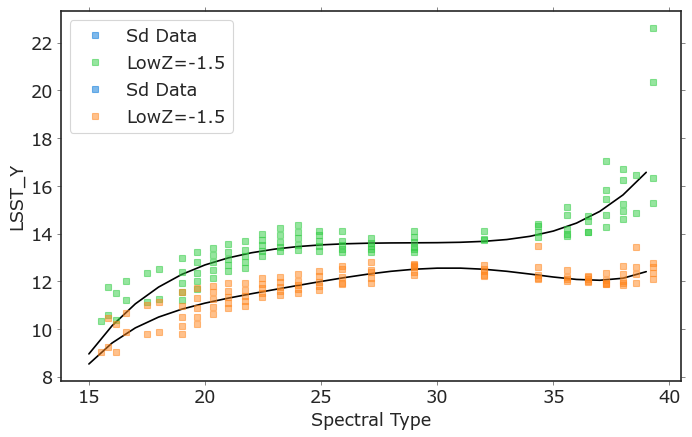

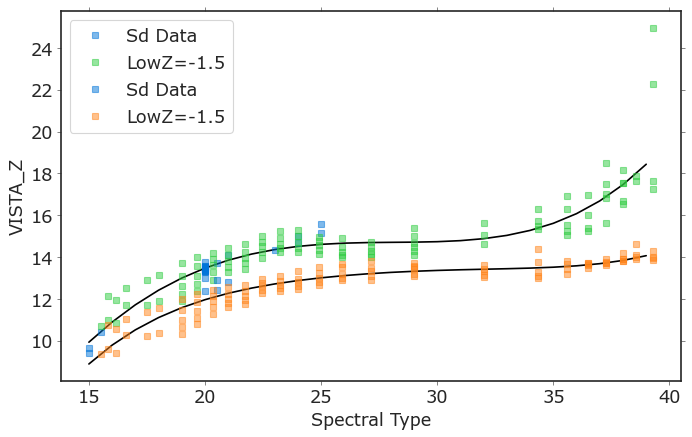

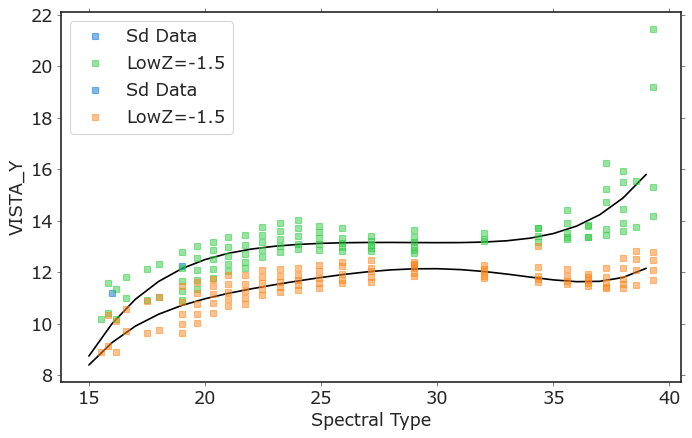

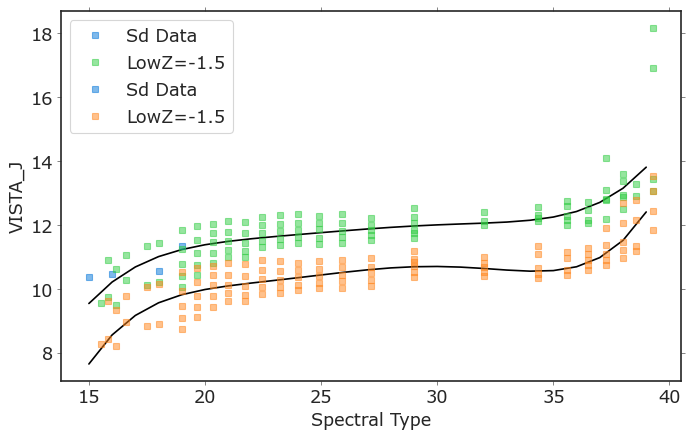

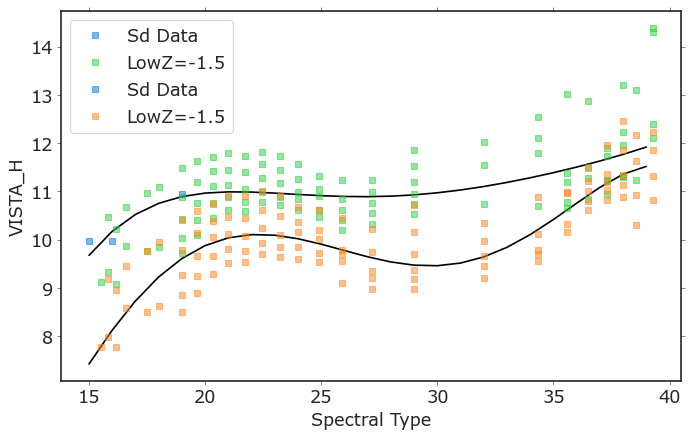

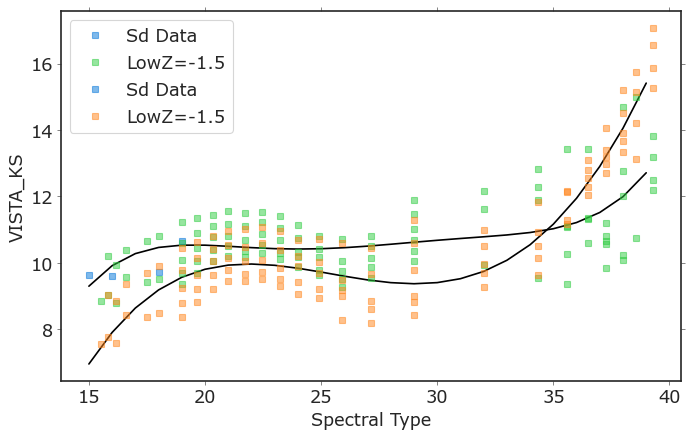

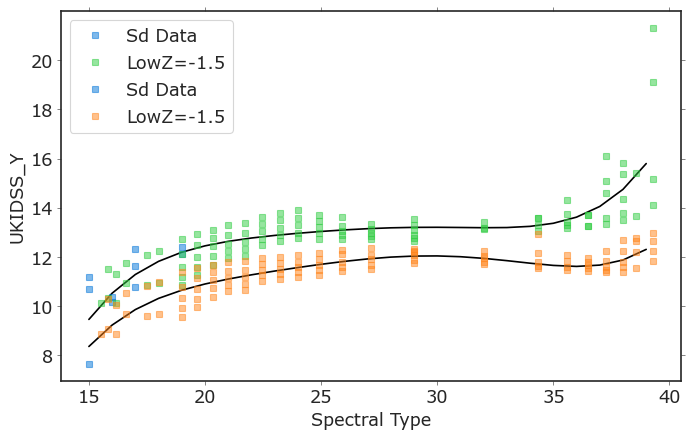

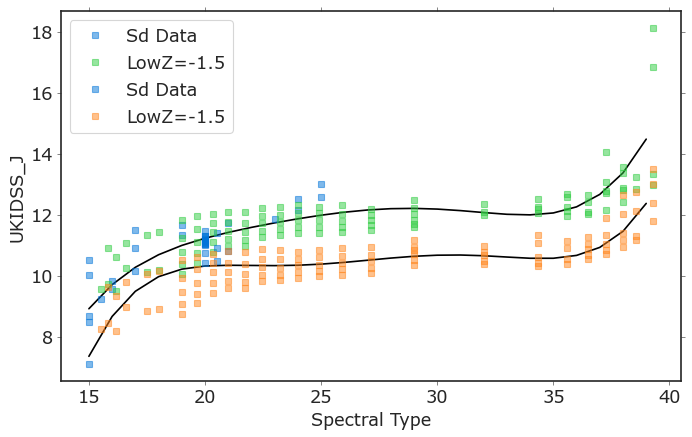

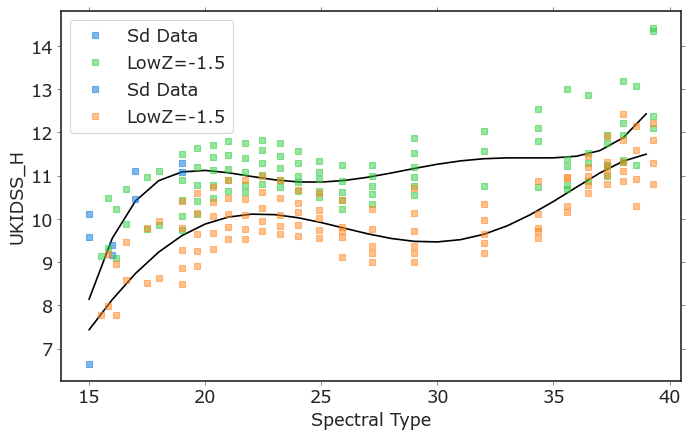

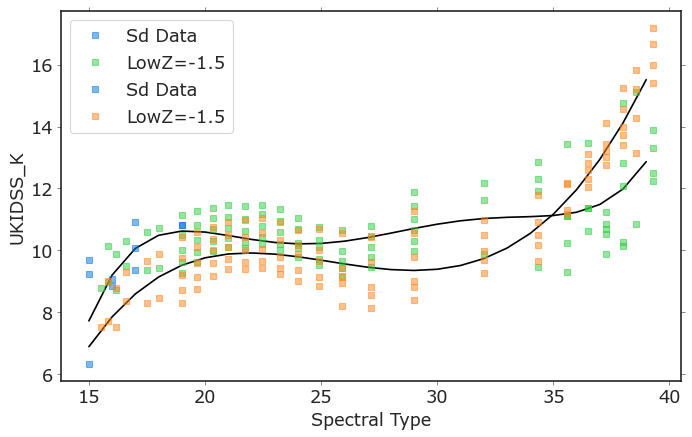

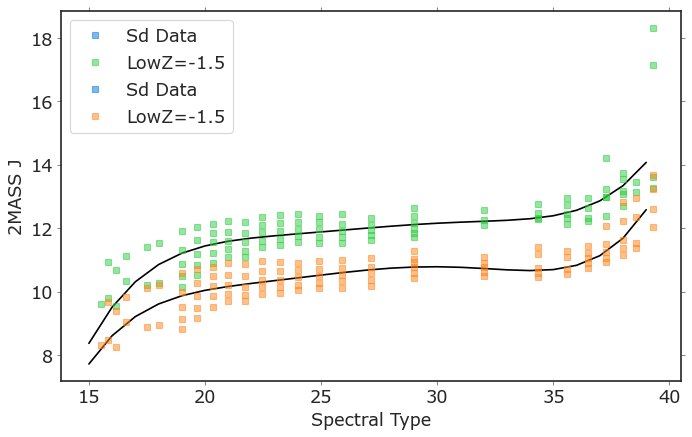

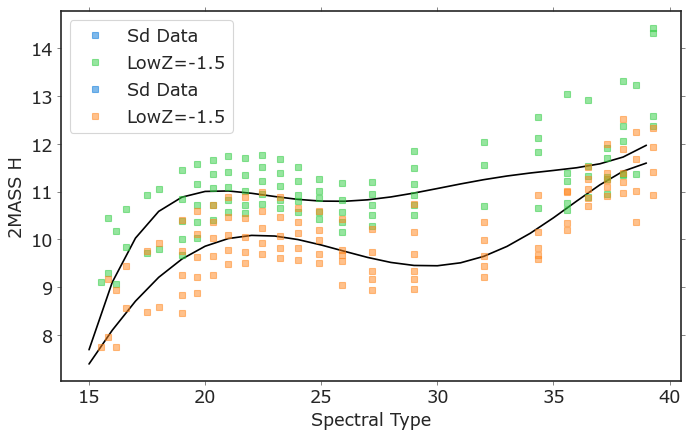

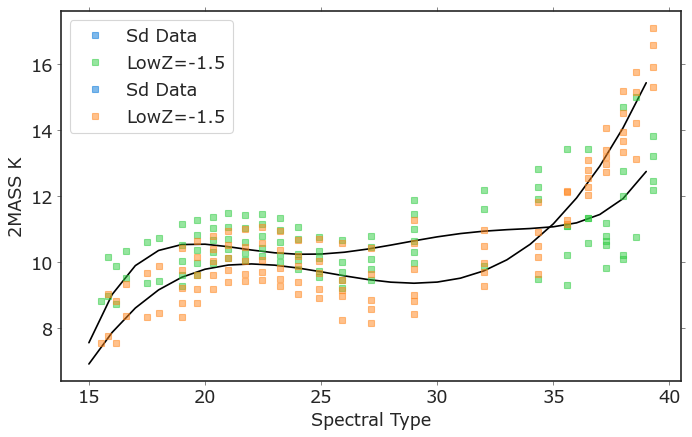

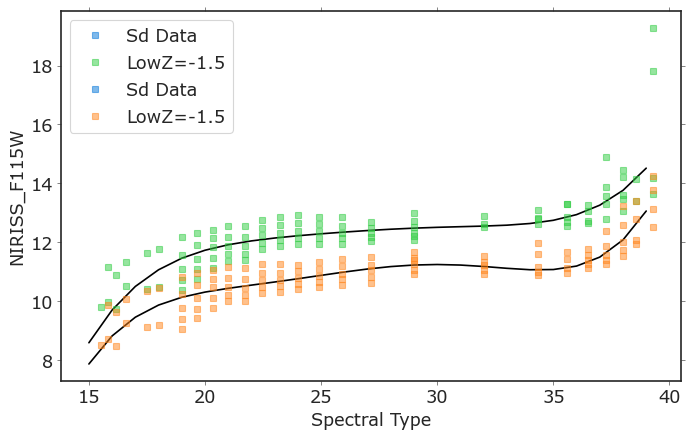

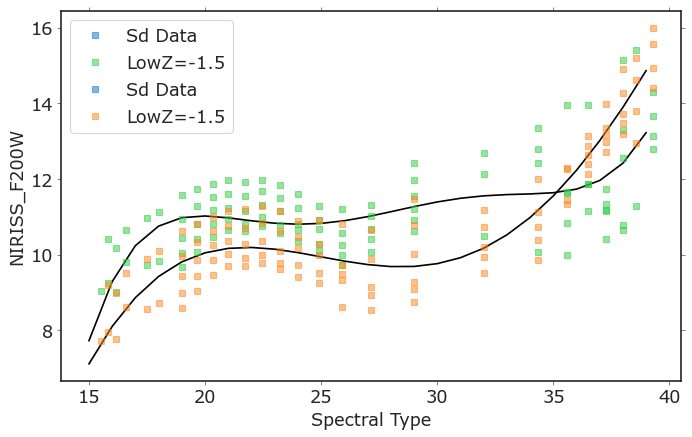

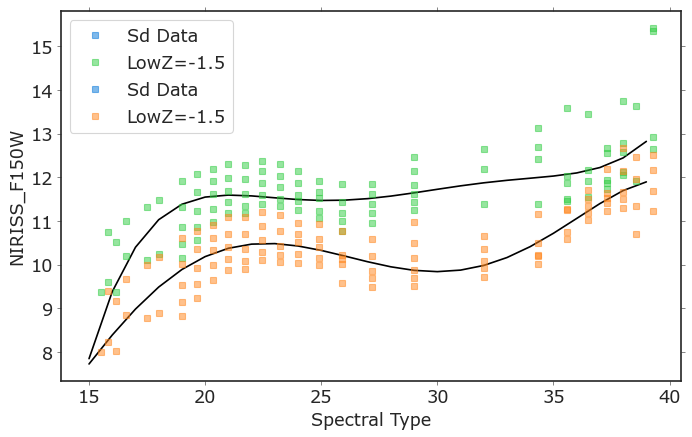

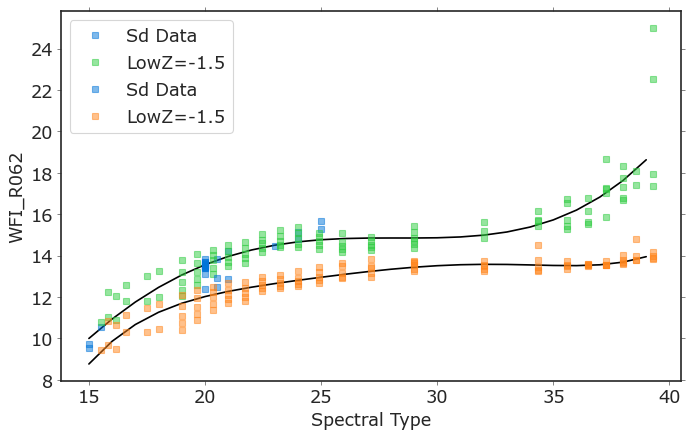

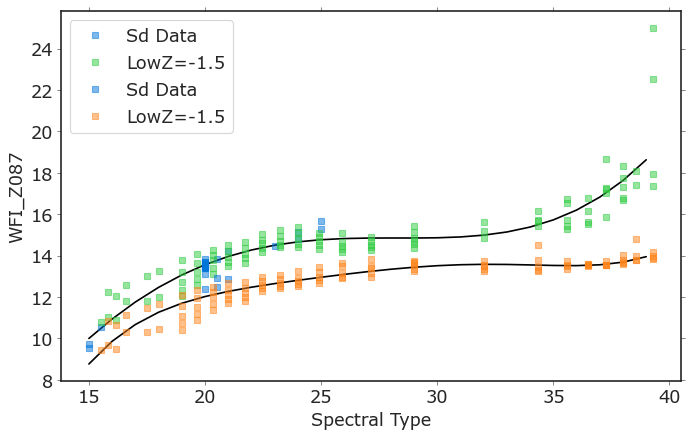

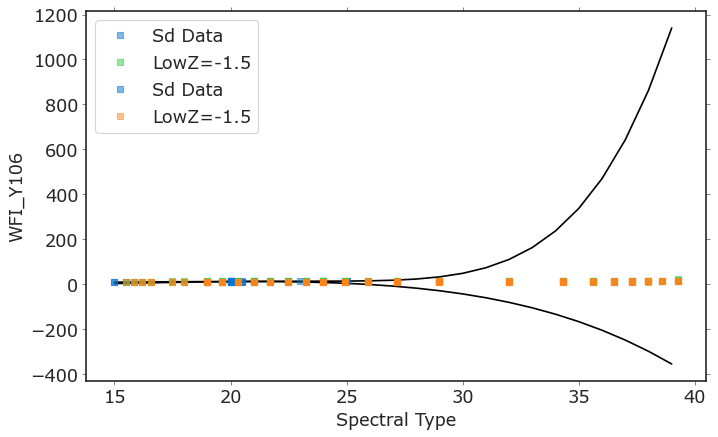

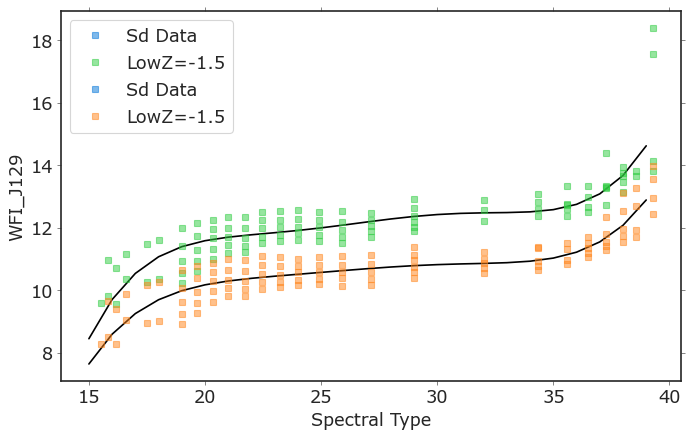

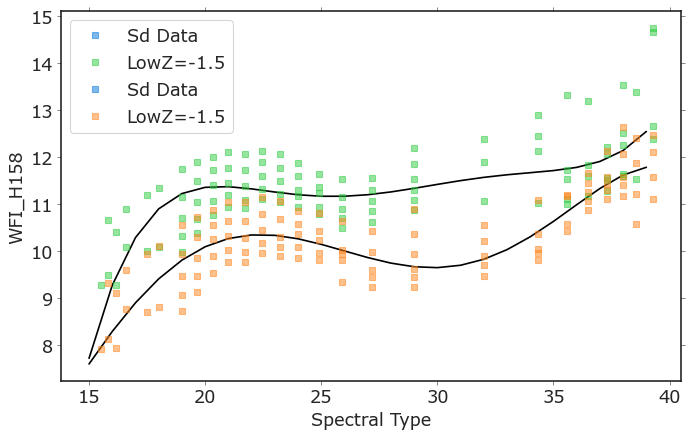

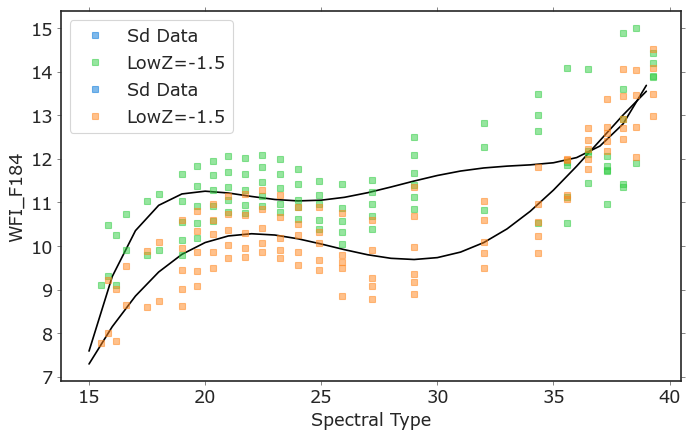

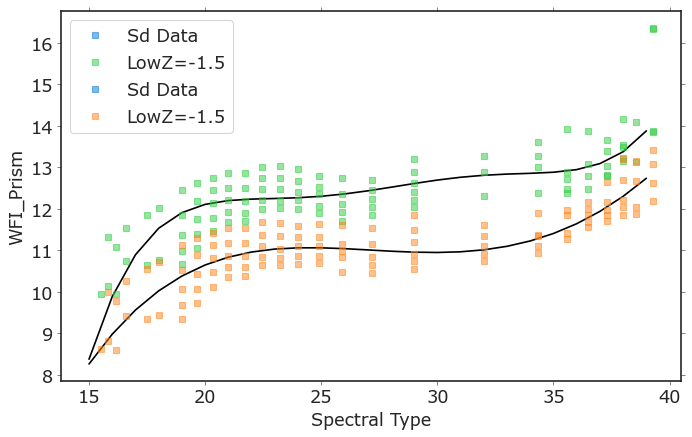

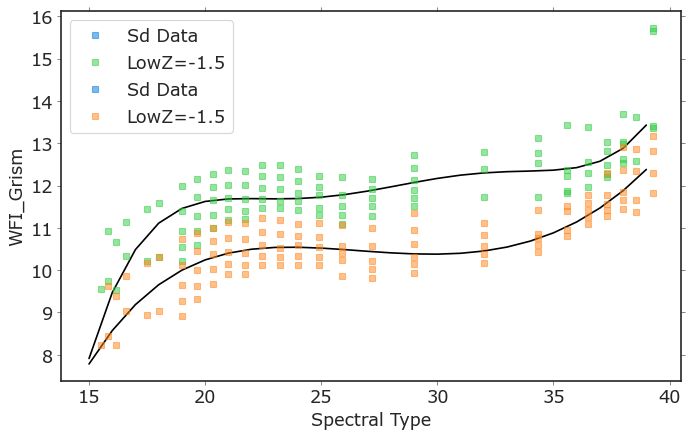

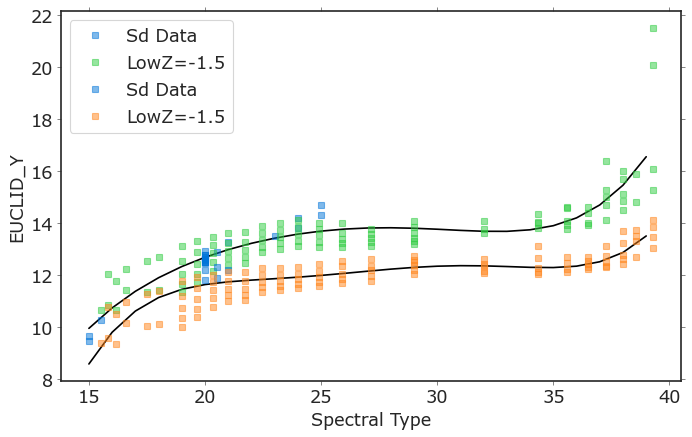

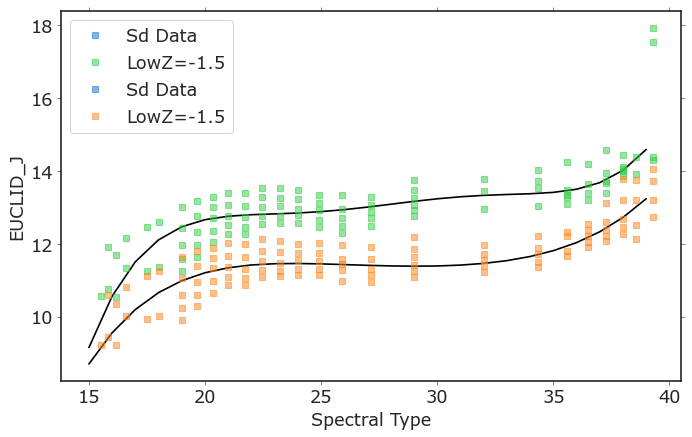

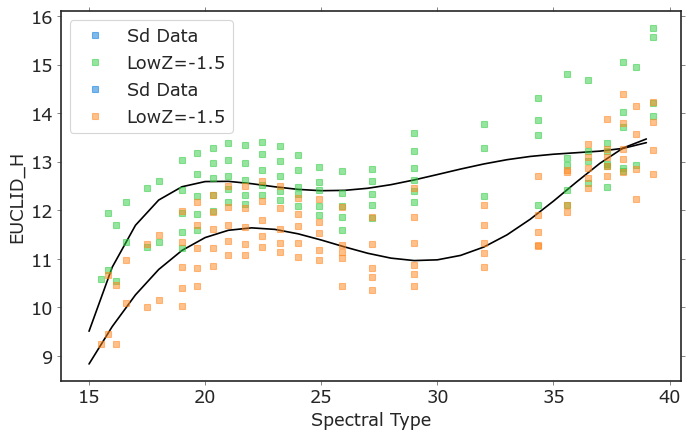

In [68]:
for k in  mag_columns_to_use:
    fig, ax=plt.subplots(figsize=(10, 6))
    
    mask_data=np.logical_and(sd_table[k]>5, sd_table.spt>14)
    mask_model=sd_models[k]>0
    
    xall= np.concatenate([sd_table.spt.values[mask_data],
                         sd_models.spt.values[mask_model]])
    
    yall= np.concatenate([sd_table[k].values[mask_data],
                         sd_models[k].values[mask_model]+SCALE_FACTORS['subdwarfs']])
    
    yerrall= np.concatenate([sd_table[k+'_er'].values[mask_data],
                         10*sd_models[k+'_er'].values[mask_model]])
                             
                             

    mask= np.logical_or.reduce([np.isnan(xall),np.isnan(yall),np.isnan(yerrall)])
    #print (mask)
    m, fit= fit_with_nsigma_clipping(xall[~mask], yall[~mask], yerrall[~mask], 5, sigma=4)

    xgrid=np.arange(15, 40)
    ax.plot(xgrid, fit(xgrid), c='k')
    
    #ax.scatter(xall[~mask], yall[~mask])

    ax.errorbar(sd_table.spt.values[mask_data], sd_table[k].values[mask_data],
                fmt='s', alpha=0.5, label='Sd Data', c='#0074D9')
    ax.errorbar(sd_models.spt.values[mask_model],  sd_models[k].values[mask_model]+SCALE_FACTORS['subdwarfs'], \
                fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')
    #print (fit(25))
    #l;''
    ax.set(xlabel='Spectral Type', ylabel=k)
    ax.legend()
    #save fits
    scatter= (np.nanmedian(yerrall[~mask])**2+ np.nanmedian((yall[~mask]-fit(xall[~mask]))**2))**0.5

    FITS['absmags_spt']['subdwarfs'].update({k: {'x': 'spt',
                                          'y': k,
                                          'fit':fit,
                                           'coeffs': fit.coefficients,
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range': (15, 39),
                                         'x0':0.}})
    
    ABS_MAG_USED['subdwarf'].update({k: {'x': xall[~mask], 
                                                      'y':yall[~mask], 
                                                      'yerr':yerrall[~mask],
                                                     }})
    
    #esds
    mask_data=np.logical_and(esd_table[k]>0, esd_table.spt>14)
    mask_model=esd_models[k]>0
    
    xall= np.concatenate([esd_table.spt.values[mask_data],
                         esd_models.spt.values[mask_model]])
    
    yall= np.concatenate([esd_table[k].values[mask_data],
                         esd_models[k].values[mask_model]+SCALE_FACTORS['esd']])
    
    yerrall= np.concatenate([esd_table[k+'_er'].values[mask_data],
                         10*esd_models[k+'_er'].values[mask_model]])
                             
                             

    mask= np.logical_or.reduce([np.isnan(xall),np.isnan(yall),np.isnan(yerrall)])
    #print (mask)
    m, fit= fit_with_nsigma_clipping(xall[~mask], yall[~mask], yerrall[~mask], 5, sigma=4)

    xgrid=np.arange(15, 40)
    ax.plot(xgrid, fit(xgrid), c='k')
    
    #ax.scatter(xall[~mask], yall[~mask])

    ax.errorbar(esd_table.spt.values[mask_data], esd_table[k].values[mask_data],
                fmt='s', alpha=0.5, label='Sd Data', c='#0074D9')
    ax.errorbar(esd_models.spt.values[mask_model],  esd_models[k].values[mask_model]+SCALE_FACTORS['esd'], \
                fmt='s', alpha=0.5, label='LowZ=-1.5', c='#FF851B')
    #print (fit(25))
    #l;''
    ax.set(xlabel='Spectral Type', ylabel=k)
    ax.legend()
    #save fits
    scatter= (np.nanmedian(yerrall[~mask])**2+ np.nanmedian((yall[~mask]-fit(xall[~mask]))**2))**0.5

    FITS['absmags_spt']['esd'].update({k: {'x': 'spt',
                                          'y': k,
                                          'fit':fit,
                                           'coeffs': fit.coefficients,
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (15, 39), \
                                         'x0':0.}})
    
    ABS_MAG_USED['esd'].update({k: {'x': xall[~mask], 
                                                      'y':yall[~mask], 
                                                      'yerr':yerrall[~mask],
                                                     }})
    
    
    plt.savefig('../figures/absmag_relations_sd|{}.jpeg'.format(k.upper()), bbox_inches='tight')
    


In [69]:
ABS_MAG_USED

{'subdwarf': {'SDSS_G': {'x': array([15.        , 15.        , 15.5       , 35.6       , 35.6       ,
          35.6       , 35.6       , 35.6       , 34.33333333, 34.33333333,
          34.33333333, 34.33333333, 32.        , 32.        , 32.        ,
          29.        , 29.        , 29.        , 29.        , 29.        ,
          29.        , 27.16666667, 27.16666667, 27.16666667, 27.16666667,
          27.16666667, 25.9       , 25.9       , 25.9       , 25.9       ,
          25.9       , 24.90909091, 24.90909091, 24.90909091, 24.90909091,
          24.90909091, 24.        , 24.        , 24.        , 24.        ,
          24.        , 23.23076923, 23.23076923, 23.23076923, 23.23076923,
          23.23076923, 22.46153846, 22.46153846, 22.46153846, 22.46153846,
          22.46153846, 21.71428571, 21.71428571, 21.71428571, 21.71428571,
          21.71428571, 21.        , 21.        , 21.        , 21.        ,
          21.        , 20.33333333, 20.33333333, 20.33333333, 20.33333333

In [70]:
bins=np.arange(10, 40)
df=pd.DataFrame()
df['spt']=['sd'+splat.typeToNum(x) for x in bins]
for k in ABS_MAG_USED['subdwarf'].keys():
    if 'LSST' not in k:
        x=ABS_MAG_USED['subdwarf'][k]['x']
        y=ABS_MAG_USED['subdwarf'][k]['y']
        yerr=ABS_MAG_USED['subdwarf'][k]['yerr']
        vls= np.vstack(bin_by_spt_bin(bins, x, y, yerr))

        df[k]=['{:.1f}+/-{:.1f}'.format(x[0], x[1]) for x in vls]

    #df=df.dropna(axis=1)
    
df.replace('nan+/-nan', '').dropna(how='all', axis=1).to_latex('/users/caganze/research/popsimsdata/subdwarfs_absmags.tex', index=False)
df.replace('nan+/-nan', '')

bins=np.arange(10, 40)
df=pd.DataFrame()
df['spt']=['esd'+splat.typeToNum(x) for x in bins]
for k in ABS_MAG_USED['esd'].keys():
    if 'LSST' not in k:
        x=ABS_MAG_USED['esd'][k]['x']
        y=ABS_MAG_USED['esd'][k]['y']
        yerr=ABS_MAG_USED['esd'][k]['yerr']
        vls= np.vstack(bin_by_spt_bin(bins, x, y, yerr))

        df[k]=['{:.1f}+/-{:.1f}'.format(x[0], x[1]) for x in vls]

    #df=df.dropna(axis=1)
    
df.replace('nan+/-nan', '').dropna(how='all', axis=1).to_latex('/users/caganze/research/popsimsdata/esds_absmags.tex', index=False)
df.replace('nan+/-nan', '')

spt      SDSS_G      SDSS_R      SDSS_I      SDSS_Z PANSTARRS_R  \
0   esdM0.0                                                               
1   esdM1.0                                                               
2   esdM2.0                                                               
3   esdM3.0                                                               
4   esdM4.0                                                               
5   esdM5.0  14.0+/-0.9  12.5+/-0.8  10.8+/-0.7  10.0+/-0.6  12.5+/-0.8   
6   esdM6.0  15.6+/-0.9  14.1+/-0.8  11.8+/-0.7  10.8+/-0.6  14.1+/-0.8   
7   esdM7.0  16.7+/-0.8  15.3+/-0.6  12.4+/-0.6  11.2+/-0.6  15.2+/-0.6   
8   esdM8.0  17.4+/-0.8  15.9+/-0.6  12.7+/-0.7  11.4+/-0.6  15.8+/-0.6   
9   esdM9.0  18.6+/-0.9  16.8+/-0.6  13.2+/-0.7  11.7+/-0.6  16.7+/-0.6   
10  esdL0.0  20.1+/-0.6  17.8+/-0.3  14.2+/-0.4  12.6+/-0.4  17.7+/-0.4   
11  esdL1.0  20.9+/-0.5  18.1+/-0.3  14.5+/-0.4  12.5+/-0.4  18.0+/-0.3   
12  esdL2.0  21.7+/-0.2  18.6+/-0.2  15.3+/-0.3  12.9+/-0.3  18.5+/-0.2   
13  esdL3.0  21.7+/-0.3  18.4+/-0.3  15.4+/-0.3  13.0+/-0.3  18.3+/-0.3   
14  esdL4.0  21.6+/-0.4  18.4+/-0.4  15.6+/-0.4  13.2+/-0.3  18.3+/-0.3   
15  esdL5.0  21.7+/-0.5  18.3+/-0.5  15.8+/-0.4  13.4+/-0.3  18.1+/-0.4   
16  esdL6.0                                                               
17  esdL7.0  21.6+/-0.5  18.1+/-0.5  15.7+/-0.4  13.6+/-0.3  17.9+/-0.5   
18  esdL8.0                                                               
19  esdL9.0  21.9+/-0.4  18.4+/-0.8  15.9+/-0.4  13.8+/-0.2  18.1+/-0.7   
20  esdT0.0                                                               
21  esdT1.0                                                               
22  esdT2.0  22.1+/-0.3  18.8+/-0.7  16.1+/-0.3  13.6+/-0.2  18.4+/-0.6   
23  esdT3.0                                                               
24  esdT4.0  22.2+/-0.6  19.7+/-0.9  16.8+/-0.3  13.5+/-0.5  19.4+/-0.8   
25  esdT5.0  22.7+/-0.2  21.7+/-0.9  17.7+/-0.1  13.6+/-0.2  21.0+/-0.8   
26  esdT6.0  22.9+/-0.2  23.2+/-0.8  18.4+/-0.2  13.7+/-0.1  22.4+/-0.7   
27  esdT7.0  23.3+/-0.3  24.4+/-0.8  19.0+/-0.3  13.6+/-0.2  23.5+/-0.8   
28  esdT8.0  24.1+/-1.8  25.1+/-0.7  19.7+/-0.6  13.8+/-0.4  24.5+/-0.8   
29  esdT9.0  23.5+/-2.5  22.1+/-3.8  20.2+/-0.5  13.9+/-0.2  21.9+/-3.4   

   PANSTARRS_I PANSTARRS_Z PANSTARRS_Y     VISTA_Z  ...    WFI_Z087  \
0                                                   ...               
1                                                   ...               
2                                                   ...               
3                                                   ...               
4                                                   ...               
5   10.8+/-0.7  10.1+/-0.6   9.8+/-0.6   9.6+/-0.6  ...   9.7+/-0.6   
6   11.8+/-0.7  10.9+/-0.6  10.6+/-0.6  10.4+/-0.6  ...  10.5+/-0.6   
7   12.3+/-0.6  11.3+/-0.6  11.0+/-0.6  10.8+/-0.6  ...  10.9+/-0.6   
8   12.6+/-0.7  11.5+/-0.6  11.1+/-0.6  11.0+/-0.6  ...  11.1+/-0.6   
9   13.1+/-0.7  11.8+/-0.6  11.3+/-0.6  11.3+/-0.6  ...  11.4+/-0.6   
10  14.2+/-0.5  12.8+/-0.5  11.8+/-0.4  12.3+/-0.5  ...  12.3+/-0.5   
11  14.6+/-0.4  12.7+/-0.4  11.9+/-0.4  12.1+/-0.4  ...  12.2+/-0.4   
12  15.2+/-0.3  13.2+/-0.3  12.3+/-0.3  12.6+/-0.3  ...  12.6+/-0.3   
13  15.3+/-0.3  13.3+/-0.3  12.3+/-0.3  12.7+/-0.3  ...  12.7+/-0.3   
14  15.6+/-0.4  13.5+/-0.3  12.5+/-0.3  12.9+/-0.3  ...  12.9+/-0.3   
15  15.7+/-0.4  13.8+/-0.3  12.7+/-0.3  13.2+/-0.3  ...  13.2+/-0.3   
16                                                  ...               
17  15.6+/-0.4  13.9+/-0.3  13.0+/-0.3  13.3+/-0.3  ...  13.4+/-0.3   
18                                                  ...               
19  15.8+/-0.4  14.1+/-0.2  13.2+/-0.2  13.5+/-0.2  ...  13.6+/-0.2   
20                                                  ...               
21                                                  ...               
22  16.0+/-0.3  13.9+/-0.2  13.1+/-0.2  13.3+/-0.

In [71]:
df.columns

Index(['spt', 'SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', 'PANSTARRS_R',
       'PANSTARRS_I', 'PANSTARRS_Z', 'PANSTARRS_Y', 'VISTA_Z', 'VISTA_Y',
       'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H',
       'UKIDSS_K', '2MASS J', '2MASS H', '2MASS K', 'NIRISS_F115W',
       'NIRISS_F200W', 'NIRISS_F150W', 'WFI_R062', 'WFI_Z087', 'WFI_Y106',
       'WFI_J129', 'WFI_H158', 'WFI_F184', 'WFI_Prism', 'WFI_Grism',
       'EUCLID_Y', 'EUCLID_J', 'EUCLID_H'],
      dtype='object')

In [72]:
np.save('/Volumes/LaCie/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 
np.save('/users/caganze/research/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 

In [73]:
FITS['absmags_spt']['subdwarfs'].keys()

dict_keys(['LSST_R', 'LSST_I', 'LSST_Z', 'SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', 'PANSTARRS_R', 'PANSTARRS_I', 'PANSTARRS_Z', 'PANSTARRS_Y', 'LSST_G', 'LSST_Y', 'VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', '2MASS J', '2MASS H', '2MASS K', 'UKIDSS_Y', 'NIRISS_F115W', 'NIRISS_F200W', 'NIRISS_F150W', 'WFI_R062', 'WFI_Z087', 'WFI_Y106', 'WFI_J129', 'WFI_H158', 'WFI_F184', 'WFI_Prism', 'WFI_Grism', 'EUCLID_Y', 'EUCLID_J', 'EUCLID_H'])

In [74]:
df.replace('nan+/-nan', '').dropna(how='all', axis=1)

spt      SDSS_G      SDSS_R      SDSS_I      SDSS_Z PANSTARRS_R  \
0   esdM0.0                                                               
1   esdM1.0                                                               
2   esdM2.0                                                               
3   esdM3.0                                                               
4   esdM4.0                                                               
5   esdM5.0  14.0+/-0.9  12.5+/-0.8  10.8+/-0.7  10.0+/-0.6  12.5+/-0.8   
6   esdM6.0  15.6+/-0.9  14.1+/-0.8  11.8+/-0.7  10.8+/-0.6  14.1+/-0.8   
7   esdM7.0  16.7+/-0.8  15.3+/-0.6  12.4+/-0.6  11.2+/-0.6  15.2+/-0.6   
8   esdM8.0  17.4+/-0.8  15.9+/-0.6  12.7+/-0.7  11.4+/-0.6  15.8+/-0.6   
9   esdM9.0  18.6+/-0.9  16.8+/-0.6  13.2+/-0.7  11.7+/-0.6  16.7+/-0.6   
10  esdL0.0  20.1+/-0.6  17.8+/-0.3  14.2+/-0.4  12.6+/-0.4  17.7+/-0.4   
11  esdL1.0  20.9+/-0.5  18.1+/-0.3  14.5+/-0.4  12.5+/-0.4  18.0+/-0.3   
12  esdL2.0  21.7+/-0.2  18.6+/-0.2  15.3+/-0.3  12.9+/-0.3  18.5+/-0.2   
13  esdL3.0  21.7+/-0.3  18.4+/-0.3  15.4+/-0.3  13.0+/-0.3  18.3+/-0.3   
14  esdL4.0  21.6+/-0.4  18.4+/-0.4  15.6+/-0.4  13.2+/-0.3  18.3+/-0.3   
15  esdL5.0  21.7+/-0.5  18.3+/-0.5  15.8+/-0.4  13.4+/-0.3  18.1+/-0.4   
16  esdL6.0                                                               
17  esdL7.0  21.6+/-0.5  18.1+/-0.5  15.7+/-0.4  13.6+/-0.3  17.9+/-0.5   
18  esdL8.0                                                               
19  esdL9.0  21.9+/-0.4  18.4+/-0.8  15.9+/-0.4  13.8+/-0.2  18.1+/-0.7   
20  esdT0.0                                                               
21  esdT1.0                                                               
22  esdT2.0  22.1+/-0.3  18.8+/-0.7  16.1+/-0.3  13.6+/-0.2  18.4+/-0.6   
23  esdT3.0                                                               
24  esdT4.0  22.2+/-0.6  19.7+/-0.9  16.8+/-0.3  13.5+/-0.5  19.4+/-0.8   
25  esdT5.0  22.7+/-0.2  21.7+/-0.9  17.7+/-0.1  13.6+/-0.2  21.0+/-0.8   
26  esdT6.0  22.9+/-0.2  23.2+/-0.8  18.4+/-0.2  13.7+/-0.1  22.4+/-0.7   
27  esdT7.0  23.3+/-0.3  24.4+/-0.8  19.0+/-0.3  13.6+/-0.2  23.5+/-0.8   
28  esdT8.0  24.1+/-1.8  25.1+/-0.7  19.7+/-0.6  13.8+/-0.4  24.5+/-0.8   
29  esdT9.0  23.5+/-2.5  22.1+/-3.8  20.2+/-0.5  13.9+/-0.2  21.9+/-3.4   

   PANSTARRS_I PANSTARRS_Z PANSTARRS_Y     VISTA_Z  ...    WFI_Z087  \
0                                                   ...               
1                                                   ...               
2                                                   ...               
3                                                   ...               
4                                                   ...               
5   10.8+/-0.7  10.1+/-0.6   9.8+/-0.6   9.6+/-0.6  ...   9.7+/-0.6   
6   11.8+/-0.7  10.9+/-0.6  10.6+/-0.6  10.4+/-0.6  ...  10.5+/-0.6   
7   12.3+/-0.6  11.3+/-0.6  11.0+/-0.6  10.8+/-0.6  ...  10.9+/-0.6   
8   12.6+/-0.7  11.5+/-0.6  11.1+/-0.6  11.0+/-0.6  ...  11.1+/-0.6   
9   13.1+/-0.7  11.8+/-0.6  11.3+/-0.6  11.3+/-0.6  ...  11.4+/-0.6   
10  14.2+/-0.5  12.8+/-0.5  11.8+/-0.4  12.3+/-0.5  ...  12.3+/-0.5   
11  14.6+/-0.4  12.7+/-0.4  11.9+/-0.4  12.1+/-0.4  ...  12.2+/-0.4   
12  15.2+/-0.3  13.2+/-0.3  12.3+/-0.3  12.6+/-0.3  ...  12.6+/-0.3   
13  15.3+/-0.3  13.3+/-0.3  12.3+/-0.3  12.7+/-0.3  ...  12.7+/-0.3   
14  15.6+/-0.4  13.5+/-0.3  12.5+/-0.3  12.9+/-0.3  ...  12.9+/-0.3   
15  15.7+/-0.4  13.8+/-0.3  12.7+/-0.3  13.2+/-0.3  ...  13.2+/-0.3   
16                                                  ...               
17  15.6+/-0.4  13.9+/-0.3  13.0+/-0.3  13.3+/-0.3  ...  13.4+/-0.3   
18                                                  ...               
19  15.8+/-0.4  14.1+/-0.2  13.2+/-0.2  13.5+/-0.2  ...  13.6+/-0.2   
20                                                  ...               
21                                                  ...               
22  16.0+/-0.3  13.9+/-0.2  13.1+/-0.2  13.3+/-0.